In [2]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Define pytorch device - useful for device-agnostic execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define model parameters
NUM_EPOCHS = 70
BATCH_SIZE = 512
IMAGE_DIM = 32  # pixels
NUM_CLASSES = 10  # 10 classes for CIFAR-10 dataset
DEVICE_IDS = [0]  # GPUs to use
OUTPUT_DIR = 'alexnet_data_out'
LOG_DIR = OUTPUT_DIR + '/tblogs'  # tensorboard logs
CHECKPOINT_DIR = OUTPUT_DIR + '/models'  # model checkpoints

# Make checkpoint path directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hack to debug in the middle of a sequential 
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

class AlexNet(nn.Module):
    """
    Neural network model consisting of layers proposed by AlexNet paper.
    """
    
    def __init__(self, num_classes=NUM_CLASSES):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()

        # Main net
        self.norm = nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(64, 192, 5, padding=1)
        self.conv3 = nn.Conv2d(192, 384, 3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu = nn.ReLU()

        self.mainConvLayers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]

        # Branch 1
        self.branch1 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75),
            nn.Conv2d(64, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.branch1fc = nn.Linear(1568, 10)

        # Branch 2
        self.branch2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75),
            nn.Conv2d(192, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.branch2fc = nn.Linear(128, 10)

        # Linear layers of main branch
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),  # inplace=False
            nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
            nn.ReLU(inplace=False),  # inplace=False
            nn.Dropout(p=0.5, inplace=False),  # inplace=False
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),  # inplace=False
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.branch1:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        for layer in self.branch2:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        for layer in self.mainConvLayers:
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.constant_(layer.bias, 0)

        # Original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv2.bias, 1)
        nn.init.constant_(self.conv4.bias, 1)
        nn.init.constant_(self.conv5.bias, 1)
        
    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        x = self.conv1(x)

        #BRANCH 1: 2 3x3 conv and one FC layer
        x1 = self.branch1(x)
        x1 = x1.view(-1, 1568)
        x1 = self.branch1fc(x1)

        x = self.relu(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.conv2(x)

        #BRANCH 2: 1 3x3 conv and one FC layer
        x2 = self.branch2(x)
        x2 = x2.view(-1, 128)
        x2 = self.branch2fc(x2)

        x = self.relu(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), 256 * 2 * 2)  # reduce the dimensions for linear layer input
        x = self.classifier(x)
        return x1, x2, x

#     def forward(self, x):
#         """
#         Pass the input through the net.
#         Args:
#             x (Tensor): input tensor
#         Returns:
#             output (Tensor): output tensor
#         """
#         b1ps = torch.tensor([0])
#         b2ps = torch.tensor([0])
# #         print(label)
#         print(f"Input shape: {x.shape}")
#         labelvector = [0] * 10
#         for I in range(10):
#             labelvector[I] = 0.1 
#         labelvector = [labelvector]
#         labelvector = torch.Tensor(labelvector).to(device)
#       #  Forward pass through conv1
#         x = self.conv1(x)
#         print(f"After conv1: {x.shape}")

#       # Forward pass through branch1
        
#         x1 = self.branch1(x)
#         x1 = x1.view(-1, 1568)
#         x1 = self.branch1fc(x1)
#         b1ps = F.softmax(x1, dim=1)
#         b1loss = F.binary_cross_entropy(b1ps, labelvector)

#         if b1loss <= 0.5:
#             return b1ps, None, None
        
# #         return b1ps, None, None
    
#        ## Continue with the rest of the layers
#         x = self.relu(x)
#         x = self.norm(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         print(f"After conv2: {x.shape}")

#         ## Forward pass through branch2
        
#         x2 = self.branch2(x)
#         x2 = x2.view(-1, 128)
#         x2 = self.branch2fc(x2)
#         b2ps = F.softmax(x2, dim=1)
#         b2loss = F.binary_cross_entropy(b2ps,labelvector)
#         if b2loss <= 0.5:
#              return b1ps, b2ps, None
#   #      return b1ps, b2ps , None

#         x = self.relu(x)
#         x = self.norm(x)
#         x = self.pool(x)
#         x = self.conv3(x)
#         print(f"After conv3: {x.shape}")
#         x = self.relu(x)
#         x = self.conv4(x)
#         print(f"After conv4: {x.shape}")
#         x = self.relu(x)
#         x = self.conv5(x)
#         print(f"After conv5: {x.shape}")
#         x = self.relu(x)
#         x = self.pool(x)
#         print(f"After final pool: {x.shape}")

#         x = x.view(x.size(0), 256 * 2 * 2)
#         x = self.classifier(x)
#         mainps = F.softmax(x,dim=1)
    
#         b1ps = "test"
#         b2ps = "test"
        
        
#         return b1ps, b2ps, mainps


if __name__ == '__main__':
    # Print the seed value
    seed = torch.initial_seed()
    print('Used seed : {}'.format(seed))
    torch.autograd.set_detect_anomaly(True)

    tbwriter = SummaryWriter(log_dir=LOG_DIR)
    print('TensorboardX summary writer created')

    # Create model
    alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
    # Train on multiple GPUs
    alexnet = torch.nn.parallel.DataParallel(alexnet, device_ids=DEVICE_IDS)
    print(alexnet)
    print('AlexNet created')

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    
    dataset = datasets.CIFAR10(root='./data', train=True, transform=transform,
                               download=True)
    
    testtransform = transforms.Compose([
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    testdata = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
    print('Dataset created')
    
    dataloader = data.DataLoader(
        dataset,
        shuffle=True,
        pin_memory=True,
        num_workers=8,
        drop_last=True,
        batch_size=BATCH_SIZE)
    print('Dataloader created')

    optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)
    print('Optimizer created')

    # Multiply LR by 1 / 10 after every 30 epochs
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    print('LR Scheduler created')

    # Start training!!
    print('Starting training...')
    alexnet.train()
    total_steps = 1
    end = False
    for epoch in range(NUM_EPOCHS):
        for imgs, classes in dataloader:
            imgs, classes = imgs.to(device), classes.to(device)
            optimizer.zero_grad()
            # Calculate the loss
            output = alexnet(imgs)[-1]
            optimizer.zero_grad()
            loss = F.cross_entropy(output, classes)

            # Update the parameters
            loss.backward()
            optimizer.step()

            # Log the information and add to tensorboard
            if total_steps % 10 == 0:
                # with torch.no_grad():
                _, preds = torch.max(output, 1)
                accuracy = torch.sum(preds == classes)

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                    .format(epoch + 1, total_steps, loss.item(), accuracy.item()))

            if total_steps % 30 == 0:
                #~~~~~~~VALIDATION~~~~~~~~~
                valdataloader = data.DataLoader(
                    testdata,
                    shuffle=True,
                    pin_memory=True,
                    num_workers=8,
                    drop_last=True,
                    batch_size=512)
                correct_count = 0
                total_count = 0
                alexnet.eval()
                for images, labels in valdataloader:
                    images, labels = images.to(device), labels.to(device)
                    with torch.no_grad():  # No gradient descent!
                        logps = alexnet(images)[-1]
                    
                    for i in range(BATCH_SIZE):
                        ps = torch.exp(logps)
                        prob = list(ps.cpu().numpy()[i])
                        pred_label = prob.index(max(prob))
                        true_label = labels.cpu().numpy()[i]
                        if true_label == pred_label:
                            correct_count += 1
                        total_count += 1
                print("Number Of Images Tested =", total_count)
                print("\nModel Accuracy =", (correct_count / total_count))
                if correct_count / total_count > 0.83:
                    end = True
                alexnet.train()
            if end:
                break

            total_steps += 1
        if end:
            break
        lr_scheduler.step()


cuda
Used seed : 2122730524526813170
TensorboardX summary writer created
DataParallel(
  (module): AlexNet(
    (norm): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (branch1): Sequential(
      (0): ReLU()
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
      (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(32, 32, kernel

Epoch: 10 	Step: 910 	Loss: 1.2314 	Acc: 273
Epoch: 10 	Step: 920 	Loss: 1.2962 	Acc: 271
Epoch: 10 	Step: 930 	Loss: 1.3450 	Acc: 255
Number Of Images Tested = 9728

Model Accuracy = 0.5524259868421053
Epoch: 10 	Step: 940 	Loss: 1.2609 	Acc: 290
Epoch: 10 	Step: 950 	Loss: 1.3407 	Acc: 270
Epoch: 10 	Step: 960 	Loss: 1.3879 	Acc: 252
Number Of Images Tested = 9728

Model Accuracy = 0.5570518092105263
Epoch: 10 	Step: 970 	Loss: 1.3198 	Acc: 276
Epoch: 11 	Step: 980 	Loss: 1.2798 	Acc: 268
Epoch: 11 	Step: 990 	Loss: 1.2984 	Acc: 267
Number Of Images Tested = 9728

Model Accuracy = 0.559827302631579
Epoch: 11 	Step: 1000 	Loss: 1.3080 	Acc: 267
Epoch: 11 	Step: 1010 	Loss: 1.1786 	Acc: 298
Epoch: 11 	Step: 1020 	Loss: 1.3279 	Acc: 274
Number Of Images Tested = 9728

Model Accuracy = 0.5518092105263158
Epoch: 11 	Step: 1030 	Loss: 1.2105 	Acc: 286
Epoch: 11 	Step: 1040 	Loss: 1.1964 	Acc: 284
Epoch: 11 	Step: 1050 	Loss: 1.2063 	Acc: 294
Number Of Images Tested = 9728

Model Accuracy =

Epoch: 22 	Step: 2110 	Loss: 1.0599 	Acc: 321
Epoch: 22 	Step: 2120 	Loss: 1.0153 	Acc: 336
Epoch: 22 	Step: 2130 	Loss: 0.9607 	Acc: 328
Number Of Images Tested = 9728

Model Accuracy = 0.6576891447368421
Epoch: 23 	Step: 2140 	Loss: 0.9602 	Acc: 336
Epoch: 23 	Step: 2150 	Loss: 1.0471 	Acc: 319
Epoch: 23 	Step: 2160 	Loss: 0.9248 	Acc: 340
Number Of Images Tested = 9728

Model Accuracy = 0.6577919407894737
Epoch: 23 	Step: 2170 	Loss: 0.9299 	Acc: 348
Epoch: 23 	Step: 2180 	Loss: 0.8715 	Acc: 361
Epoch: 23 	Step: 2190 	Loss: 1.0122 	Acc: 327
Number Of Images Tested = 9728

Model Accuracy = 0.663342927631579
Epoch: 23 	Step: 2200 	Loss: 0.9227 	Acc: 359
Epoch: 23 	Step: 2210 	Loss: 0.9631 	Acc: 329
Epoch: 23 	Step: 2220 	Loss: 1.0266 	Acc: 324
Number Of Images Tested = 9728

Model Accuracy = 0.6732113486842105
Epoch: 23 	Step: 2230 	Loss: 0.9294 	Acc: 340
Epoch: 24 	Step: 2240 	Loss: 0.8641 	Acc: 347
Epoch: 24 	Step: 2250 	Loss: 0.9032 	Acc: 351
Number Of Images Tested = 9728

Model A

Epoch: 35 	Step: 3310 	Loss: 0.8038 	Acc: 364
Epoch: 35 	Step: 3320 	Loss: 0.7609 	Acc: 382
Epoch: 35 	Step: 3330 	Loss: 0.7649 	Acc: 370
Number Of Images Tested = 9728

Model Accuracy = 0.7147409539473685
Epoch: 35 	Step: 3340 	Loss: 0.8396 	Acc: 361
Epoch: 35 	Step: 3350 	Loss: 0.7485 	Acc: 373
Epoch: 35 	Step: 3360 	Loss: 0.7760 	Acc: 376
Number Of Images Tested = 9728

Model Accuracy = 0.7110402960526315
Epoch: 35 	Step: 3370 	Loss: 0.7269 	Acc: 382
Epoch: 35 	Step: 3380 	Loss: 0.7356 	Acc: 382
Epoch: 35 	Step: 3390 	Loss: 0.6852 	Acc: 390
Number Of Images Tested = 9728

Model Accuracy = 0.7153577302631579
Epoch: 36 	Step: 3400 	Loss: 0.7846 	Acc: 376
Epoch: 36 	Step: 3410 	Loss: 0.8215 	Acc: 364
Epoch: 36 	Step: 3420 	Loss: 0.8070 	Acc: 370
Number Of Images Tested = 9728

Model Accuracy = 0.712171052631579
Epoch: 36 	Step: 3430 	Loss: 0.8266 	Acc: 366
Epoch: 36 	Step: 3440 	Loss: 0.8094 	Acc: 366
Epoch: 36 	Step: 3450 	Loss: 0.7823 	Acc: 367
Number Of Images Tested = 9728

Model A

Epoch: 47 	Step: 4510 	Loss: 0.7284 	Acc: 377
Epoch: 47 	Step: 4520 	Loss: 0.6741 	Acc: 386
Epoch: 47 	Step: 4530 	Loss: 0.7841 	Acc: 371
Number Of Images Tested = 9728

Model Accuracy = 0.7179276315789473
Epoch: 47 	Step: 4540 	Loss: 0.7499 	Acc: 380
Epoch: 47 	Step: 4550 	Loss: 0.7043 	Acc: 391
Epoch: 48 	Step: 4560 	Loss: 0.7031 	Acc: 392
Number Of Images Tested = 9728

Model Accuracy = 0.719983552631579
Epoch: 48 	Step: 4570 	Loss: 0.8245 	Acc: 360
Epoch: 48 	Step: 4580 	Loss: 0.7622 	Acc: 375
Epoch: 48 	Step: 4590 	Loss: 0.7335 	Acc: 377
Number Of Images Tested = 9728

Model Accuracy = 0.7200863486842105
Epoch: 48 	Step: 4600 	Loss: 0.7507 	Acc: 378
Epoch: 48 	Step: 4610 	Loss: 0.7889 	Acc: 364
Epoch: 48 	Step: 4620 	Loss: 0.7974 	Acc: 370
Number Of Images Tested = 9728

Model Accuracy = 0.7224506578947368
Epoch: 48 	Step: 4630 	Loss: 0.7995 	Acc: 370
Epoch: 48 	Step: 4640 	Loss: 0.7131 	Acc: 372
Epoch: 48 	Step: 4650 	Loss: 0.6873 	Acc: 381
Number Of Images Tested = 9728

Model A

Epoch: 59 	Step: 5710 	Loss: 0.7156 	Acc: 381
Epoch: 59 	Step: 5720 	Loss: 0.7227 	Acc: 383
Epoch: 60 	Step: 5730 	Loss: 0.6808 	Acc: 394
Number Of Images Tested = 9728

Model Accuracy = 0.729235197368421
Epoch: 60 	Step: 5740 	Loss: 0.6944 	Acc: 376
Epoch: 60 	Step: 5750 	Loss: 0.7102 	Acc: 380
Epoch: 60 	Step: 5760 	Loss: 0.7198 	Acc: 379
Number Of Images Tested = 9728

Model Accuracy = 0.7220394736842105
Epoch: 60 	Step: 5770 	Loss: 0.6636 	Acc: 390
Epoch: 60 	Step: 5780 	Loss: 0.7430 	Acc: 385
Epoch: 60 	Step: 5790 	Loss: 0.7449 	Acc: 380
Number Of Images Tested = 9728

Model Accuracy = 0.7281044407894737
Epoch: 60 	Step: 5800 	Loss: 0.6620 	Acc: 389
Epoch: 60 	Step: 5810 	Loss: 0.7093 	Acc: 382
Epoch: 60 	Step: 5820 	Loss: 0.7015 	Acc: 388
Number Of Images Tested = 9728

Model Accuracy = 0.7202919407894737
Epoch: 61 	Step: 5830 	Loss: 0.7412 	Acc: 374
Epoch: 61 	Step: 5840 	Loss: 0.7159 	Acc: 387
Epoch: 61 	Step: 5850 	Loss: 0.6428 	Acc: 401
Number Of Images Tested = 9728

Model A

In [ ]:
NUM_EPOCHS = 50
alexnet.train()
total_steps = 1
end = False
for epoch in range(NUM_EPOCHS):
    for imgs, classes in dataloader:
        imgs, classes = imgs.to(device), classes.to(device)
        optimizer.zero_grad()
        # Calculate the loss
        output = alexnet(imgs)[-1]
        optimizer.zero_grad()
        loss = F.cross_entropy(output, classes)

        # Update the parameters
        loss.backward()
        optimizer.step()

        # Log the information and add to tensorboard
        if total_steps % 10 == 0:
            # with torch.no_grad():
            _, preds = torch.max(output, 1)
            accuracy = torch.sum(preds == classes)

            print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                .format(epoch + 1, total_steps, loss.item(), accuracy.item()))

        if total_steps % 30 == 0:
            #~~~~~~~VALIDATION~~~~~~~~~
            valdataloader = data.DataLoader(
                testdata,
                shuffle=True,
                pin_memory=True,
                num_workers=8,
                drop_last=True,
                batch_size=512)
            correct_count = 0
            total_count = 0
            alexnet.eval()
            for images, labels in valdataloader:
                images, labels = images.to(device), labels.to(device)
                with torch.no_grad():  # No gradient descent!
                    logps = alexnet(images)[-1]

                for i in range(BATCH_SIZE):
                    ps = torch.exp(logps)
                    prob = list(ps.cpu().numpy()[i])
                    pred_label = prob.index(max(prob))
                    true_label = labels.cpu().numpy()[i]
                    if true_label == pred_label:
                        correct_count += 1
                    total_count += 1
            print("Number Of Images Tested =", total_count)
            print("\nModel Accuracy =", (correct_count / total_count))
            if correct_count / total_count > 0.83:
                end = True
            alexnet.train()
        if end:
            break

        total_steps += 1
    if end:
        break
    lr_scheduler.step()

# Testing

In [17]:
!pip install --upgrade tqdm



Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.31 requires certifi==2023.7.22, but you have certifi 2019.11.28 which is incompatible.
roboflow 1.1.31 requires cycler==0.10.0, but you have cycler 0.12.1 which is incompatible.
roboflow 1.1.31 requires idna==2.10, but you have idna 2.8 which is incompatible.
roboflow 1.1.31 requires urllib3>=1.26.6, but you have urllib3 1.25.8 which is incompatible.

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,
                               download=True)
dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0
alexnet.eval()
for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[-1]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1

    if total_count % 10 == 0:
        print(f"total: {total_count}, correct: {correct_count}")
print("Number Of Images Tested =", total_count)
print("\nModel Accuracy =", (correct_count/total_count))


Files already downloaded and verified
total: 320, correct: 98
total: 640, correct: 216
total: 960, correct: 332
total: 1280, correct: 443
total: 1600, correct: 542
total: 1920, correct: 654
total: 2240, correct: 773
total: 2560, correct: 876
total: 2880, correct: 988
total: 3200, correct: 1097
total: 3520, correct: 1202
total: 3840, correct: 1301
total: 4160, correct: 1410
total: 4480, correct: 1525
total: 4800, correct: 1637
total: 5120, correct: 1735
total: 5440, correct: 1842
total: 5760, correct: 1945
total: 6080, correct: 2061
total: 6400, correct: 2165
total: 6720, correct: 2276
total: 7040, correct: 2382
total: 7360, correct: 2481
total: 7680, correct: 2593
total: 8000, correct: 2715
total: 8320, correct: 2837
total: 8640, correct: 2949
total: 8960, correct: 3051
total: 9280, correct: 3160
total: 9600, correct: 3265
total: 9920, correct: 3375
Number Of Images Tested = 9984

Model Accuracy = 0.34004407051282054


NameError: name 'model' is not defined

# Look at the weights

In [6]:
with torch.no_grad():
    # print and save the grad of the parameters
    # also print and save parameter values
    print('*' * 10)
    for name, parameter in alexnet.named_parameters():
        if parameter.grad is not None:
            avg_grad = torch.mean(parameter.grad)
            print('\t{} - grad_avg: {}'.format(name, avg_grad))
            tbwriter.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
            tbwriter.add_histogram('grad/{}'.format(name),
                    parameter.grad.cpu().numpy(), total_steps)
        if parameter.data is not None:
            avg_weight = torch.mean(parameter.data)
            print('\t{} - param_avg: {}'.format(name, avg_weight))
            tbwriter.add_histogram('weight/{}'.format(name),
                    parameter.data.cpu().numpy(), total_steps)
            tbwriter.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)

**********
	module.conv1.weight - param_avg: -1.5114000234461855e-05
	module.conv1.bias - param_avg: 0.007356448099017143
	module.conv2.weight - param_avg: -0.005947154480963945
	module.conv2.bias - param_avg: 0.9938942790031433
	module.conv3.weight - param_avg: -0.002979485783725977
	module.conv3.bias - param_avg: 0.003147104289382696
	module.conv4.weight - param_avg: -0.002920669037848711
	module.conv4.bias - param_avg: 0.9833923578262329
	module.conv5.weight - param_avg: -0.004920501261949539
	module.conv5.bias - param_avg: 0.9856159090995789
	module.branch1.3.weight - param_avg: 7.2280723543372e-05
	module.branch1.3.bias - param_avg: 0.0
	module.branch1.5.weight - param_avg: -5.140115536050871e-05
	module.branch1.5.bias - param_avg: 0.0
	module.branch1fc.weight - param_avg: 0.00012343908019829541
	module.branch1fc.bias - param_avg: -0.0017546952003613114
	module.branch2.3.weight - param_avg: -4.547699791146442e-05
	module.branch2.3.bias - param_avg: 0.0
	module.branch2fc.weight - p

# Testing to confirm branches did NOT learn

In [7]:
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,
                               download=True)
dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0
alexnet.eval()
for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[0]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1

print("\nBranch1 Accuracy =", (correct_count/total_count))

testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,
                               download=True)
dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0
alexnet.eval()
for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[1]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1

print("\nBranch2 Accuracy =", (correct_count/total_count))

Files already downloaded and verified

Branch1 Accuracy = 0.11568509615384616
Files already downloaded and verified

Branch2 Accuracy = 0.08393429487179487


# Train now with branches

In [17]:
NUM_EPOCHS = 70

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(15),
        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform,
                            download=True)

testtransform = transforms.Compose([
    transforms.CenterCrop(IMAGE_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
testdata = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
print('Dataset created')

dataloader = data.DataLoader(
    dataset,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
print('Dataloader created')

optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)
print('Optimizer created')

# multiply LR by 1 / 10 after every 30 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
print('LR Scheduler created')

# start training!!
print('Starting training...')
alexnet.train()
total_steps = 1
end = False
for epoch in range(NUM_EPOCHS):
    for imgs, classes in dataloader:
        imgs, classes = imgs.to(device), classes.to(device)
        optimizer.zero_grad()
        # calculate the loss
        outputb1, outputb2, outputmain = alexnet(imgs)
        lossb1 = F.cross_entropy(outputb1, classes)
        lossb2 = F.cross_entropy(outputb2, classes)
        lossmain = F.cross_entropy(outputmain, classes)
        loss = lossb1 + 0.5*lossb2 + 0.2*lossmain

        # update the parameters
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 10 == 0:
            #with torch.no_grad():
            _, preds = torch.max(outputmain, 1)
            accuracy = torch.sum(preds == classes)

            print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                .format(epoch + 1, total_steps, loss.item(), accuracy.item()))
            print(f'Branch 1: loss {lossb1}')
            print(f'Branch 2: loss {lossb2}')
            print(f'Main: loss {lossmain}')

        if total_steps % 300 == 0:

            #~~~~~~~VALIDATION~~~~~~~~~
            valdataloader = data.DataLoader(
                testdata,
                shuffle=True,
                pin_memory=True,
                num_workers=8,
                drop_last=True,
                batch_size=128)
            b1_correct = 0
            b2_correct = 0
            main_correct = 0
            total_count = 0
            alexnet.eval()
            for image, label in valdataloader:
                image, label = image.to(device), label.to(device)
                with torch.no_grad(): #no gradient descent!
                    b1, b2, main = alexnet(image)
                
                b1ps = torch.exp(b1)
                b2ps = torch.exp(b2)
                mainps = torch.exp(main)
                for i in range(BATCH_SIZE):
                    b1prob = list(b1ps.cpu().numpy()[i])
                    b2prob = list(b2ps.cpu().numpy()[i])
                    mainprob = list(main.cpu().numpy()[i])


                    b1label = b1prob.index(max(b1prob))
                    b2label = b2prob.index(max(b2prob))
                    mainlabel = mainprob.index(max(mainprob))

                    true_label = label.cpu().numpy()[i]

                    if(true_label == b1label):
                        b1_correct += 1

                    if(true_label == b2label):
                        b2_correct += 1

                    if(true_label == mainlabel):
                        main_correct += 1

                    total_count += 1
                    if(total_count > 1500):
                        break
            print("Number Of Images Tested =", total_count*128)
            print(f"b1 acc: {b1_correct/total_count}, b2 acc: {b2_correct/total_count}, main acc: {main_correct/total_count}")
            alexnet.train()
        if end:
            break

        total_steps += 1
    if end:
        break
    lr_scheduler.step()

Files already downloaded and verified
Files already downloaded and verified
Dataset created
Dataloader created
Optimizer created
LR Scheduler created
Starting training...
Epoch: 1 	Step: 10 	Loss: 4.5493 	Acc: 0
Branch 1: loss 1.014906883239746
Branch 2: loss 5.824447154998779
Main: loss 3.11106014251709
Epoch: 1 	Step: 20 	Loss: 2.7624 	Acc: 1
Branch 1: loss 2.2941784858703613
Branch 2: loss 0.6636115312576294
Main: loss 0.6819270849227905
Epoch: 1 	Step: 30 	Loss: 2.5345 	Acc: 1
Branch 1: loss 2.4819765090942383
Branch 2: loss 0.10421492904424667
Main: loss 0.001905888901092112
Epoch: 1 	Step: 40 	Loss: 3.5448 	Acc: 1
Branch 1: loss 2.5177814960479736
Branch 2: loss 2.043489933013916
Main: loss 0.026456261053681374
Epoch: 1 	Step: 50 	Loss: 3.5850 	Acc: 1
Branch 1: loss 2.6100192070007324
Branch 2: loss 1.9380624294281006
Main: loss 0.02982516586780548
Epoch: 1 	Step: 60 	Loss: 3.7976 	Acc: 0
Branch 1: loss 2.50453782081604
Branch 2: loss 1.7614670991897583
Main: loss 2.0616555213928

Epoch: 1 	Step: 580 	Loss: 1.4967 	Acc: 0
Branch 1: loss 0.9849064946174622
Branch 2: loss 0.40091672539711
Main: loss 1.556677222251892
Epoch: 1 	Step: 590 	Loss: 2.0777 	Acc: 1
Branch 1: loss 1.2659138441085815
Branch 2: loss 1.1898423433303833
Main: loss 1.0843555927276611
Epoch: 1 	Step: 600 	Loss: 2.2584 	Acc: 0
Branch 1: loss 1.5135674476623535
Branch 2: loss 0.6944766640663147
Main: loss 1.987994909286499
Number Of Images Tested = 9984
b1 acc: 0.48717948717948717, b2 acc: 0.6153846153846154, main acc: 0.6538461538461539
Epoch: 1 	Step: 610 	Loss: 4.9065 	Acc: 0
Branch 1: loss 2.5563910007476807
Branch 2: loss 2.2770326137542725
Main: loss 6.057898998260498
Epoch: 1 	Step: 620 	Loss: 2.7777 	Acc: 1
Branch 1: loss 2.1683499813079834
Branch 2: loss 0.9748051166534424
Main: loss 0.609973132610321
Epoch: 1 	Step: 630 	Loss: 1.6752 	Acc: 1
Branch 1: loss 1.3677771091461182
Branch 2: loss 0.6146307587623596
Main: loss 0.000764792668633163
Epoch: 1 	Step: 640 	Loss: 0.8547 	Acc: 0
Branc

KeyboardInterrupt: 

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data augmentation and normalization for training and testing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.CenterCrop(IMAGE_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

testtransform = transforms.Compose([
    transforms.CenterCrop(IMAGE_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
testdata = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
print('Dataset created')

dataloader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE
)
print('Dataloader created')

# Initialize model, optimizer, and learning rate scheduler
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('Optimizer and LR Scheduler created')

# Training loop
NUM_EPOCHS = 70
total_steps = 1

for epoch in range(NUM_EPOCHS):
    alexnet.train()
    for imgs, classes in dataloader:
        imgs, classes = imgs.to(device), classes.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputb1, outputb2, outputmain = alexnet(imgs)

        # Calculate loss
        lossb1 = F.cross_entropy(outputb1, classes)
        lossb2 = F.cross_entropy(outputb2, classes)
        lossmain = F.cross_entropy(outputmain, classes)
        loss = lossb1 + 0.6*lossb2 + 0.3*lossmain

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if total_steps % 10 == 0:
            _, preds = torch.max(outputmain, 1)
            accuracy = torch.sum(preds == classes).item() / BATCH_SIZE

            print(f'Epoch: {epoch + 1} \tStep: {total_steps} \tLoss: {loss.item():.4f} \tAcc: {accuracy:.4f}')
            print(f'Branch 1: loss {lossb1:.4f}')
            print(f'Branch 2: loss {lossb2:.4f}')
            print(f'Main: loss {lossmain:.4f}')

        if total_steps % 300 == 0:
            # Validation
            valdataloader = torch.utils.data.DataLoader(
                testdata,
                shuffle=True,
                pin_memory=True,
                num_workers=8,
                drop_last=True,
                batch_size=128
            )
            b1_correct = 0
            b2_correct = 0
            main_correct = 0
            total_count = 0
            alexnet.eval()
            with torch.no_grad():
                for image, label in valdataloader:
                    image, label = image.to(device), label.to(device)
                    b1, b2, main = alexnet(image)

                    _, b1_preds = torch.max(b1, 1)
                    _, b2_preds = torch.max(b2, 1)
                    _, main_preds = torch.max(main, 1)

                    b1_correct += (b1_preds == label).sum().item()
                    b2_correct += (b2_preds == label).sum().item()
                    main_correct += (main_preds == label).sum().item()
                    total_count += label.size(0)

                    if total_count > 1500:
                        break

            print("Number Of Images Tested =", total_count)
            print(f"b1 acc: {b1_correct / total_count:.4f}, b2 acc: {b2_correct / total_count:.4f}, main acc: {main_correct / total_count:.4f}")
            alexnet.train()

        total_steps += 1

    lr_scheduler.step()


Files already downloaded and verified
Files already downloaded and verified
Dataset created
Dataloader created
Optimizer and LR Scheduler created
Epoch: 1 	Step: 10 	Loss: 4.8833 	Acc: 0.0000
Branch 1: loss 2.3120
Branch 2: loss 2.5517
Main: loss 3.4679
Epoch: 1 	Step: 20 	Loss: 5.0165 	Acc: 0.0000
Branch 1: loss 2.2944
Branch 2: loss 2.4991
Main: loss 4.0755
Epoch: 1 	Step: 30 	Loss: 4.5102 	Acc: 0.0000
Branch 1: loss 2.2972
Branch 2: loss 2.2661
Main: loss 2.8445
Epoch: 1 	Step: 40 	Loss: 4.2090 	Acc: 0.0000
Branch 1: loss 2.2960
Branch 2: loss 2.1317
Main: loss 2.1130
Epoch: 1 	Step: 50 	Loss: 5.0096 	Acc: 0.0000
Branch 1: loss 2.3442
Branch 2: loss 2.7414
Main: loss 3.4022
Epoch: 1 	Step: 60 	Loss: 4.3495 	Acc: 0.0000
Branch 1: loss 2.2932
Branch 2: loss 2.2341
Main: loss 2.3862
Epoch: 1 	Step: 70 	Loss: 4.2466 	Acc: 0.0000
Branch 1: loss 2.3099
Branch 2: loss 2.2012
Main: loss 2.0534
Epoch: 1 	Step: 80 	Loss: 4.7639 	Acc: 0.0000
Branch 1: loss 2.3537
Branch 2: loss 2.6035
Main: lo

Epoch: 1 	Step: 740 	Loss: 3.8888 	Acc: 0.0000
Branch 1: loss 2.1238
Branch 2: loss 1.7773
Main: loss 2.3291
Epoch: 1 	Step: 750 	Loss: 3.4924 	Acc: 0.0000
Branch 1: loss 1.5373
Branch 2: loss 2.1123
Main: loss 2.2924
Epoch: 1 	Step: 760 	Loss: 3.2708 	Acc: 0.0000
Branch 1: loss 1.1482
Branch 2: loss 2.3802
Main: loss 2.3148
Epoch: 1 	Step: 770 	Loss: 3.7985 	Acc: 0.0000
Branch 1: loss 1.8757
Branch 2: loss 2.0551
Main: loss 2.2991
Epoch: 1 	Step: 780 	Loss: 3.7326 	Acc: 0.0000
Branch 1: loss 1.7865
Branch 2: loss 2.1023
Main: loss 2.2822
Epoch: 1 	Step: 790 	Loss: 4.5718 	Acc: 0.0000
Branch 1: loss 2.3333
Branch 2: loss 2.5408
Main: loss 2.3801
Epoch: 1 	Step: 800 	Loss: 4.5092 	Acc: 0.0000
Branch 1: loss 2.3282
Branch 2: loss 2.4448
Main: loss 2.3806
Epoch: 1 	Step: 810 	Loss: 5.0440 	Acc: 0.0000
Branch 1: loss 3.0992
Branch 2: loss 2.1017
Main: loss 2.2792
Epoch: 1 	Step: 820 	Loss: 4.2680 	Acc: 0.0000
Branch 1: loss 2.2385
Branch 2: loss 2.2446
Main: loss 2.2759
Epoch: 1 	Step: 830

Epoch: 1 	Step: 1480 	Loss: 3.7366 	Acc: 0.0000
Branch 1: loss 1.7306
Branch 2: loss 2.2076
Main: loss 2.2715
Epoch: 1 	Step: 1490 	Loss: 4.9043 	Acc: 0.0000
Branch 1: loss 2.6974
Branch 2: loss 2.5291
Main: loss 2.2982
Epoch: 1 	Step: 1500 	Loss: 3.9200 	Acc: 0.0000
Branch 1: loss 1.8481
Branch 2: loss 2.2742
Main: loss 2.3577
Number Of Images Tested = 1536
b1 acc: 0.2500, b2 acc: 0.1771, main acc: 0.1022
Epoch: 1 	Step: 1510 	Loss: 4.3506 	Acc: 1.0000
Branch 1: loss 2.1892
Branch 2: loss 2.4965
Main: loss 2.2117
Epoch: 1 	Step: 1520 	Loss: 4.0897 	Acc: 0.0000
Branch 1: loss 2.0093
Branch 2: loss 2.3500
Main: loss 2.2347
Epoch: 1 	Step: 1530 	Loss: 4.2826 	Acc: 0.0000
Branch 1: loss 2.2316
Branch 2: loss 2.2364
Main: loss 2.3638
Epoch: 1 	Step: 1540 	Loss: 4.3922 	Acc: 0.0000
Branch 1: loss 2.3037
Branch 2: loss 2.3049
Main: loss 2.3518
Epoch: 1 	Step: 1550 	Loss: 3.9908 	Acc: 0.0000
Branch 1: loss 2.0390
Branch 2: loss 2.1452
Main: loss 2.2156
Epoch: 1 	Step: 1560 	Loss: 4.4433 	Acc:

Epoch: 1 	Step: 2210 	Loss: 3.8939 	Acc: 0.0000
Branch 1: loss 1.9904
Branch 2: loss 2.0265
Main: loss 2.2920
Epoch: 1 	Step: 2220 	Loss: 3.6780 	Acc: 0.0000
Branch 1: loss 1.8589
Branch 2: loss 1.8895
Main: loss 2.2847
Epoch: 1 	Step: 2230 	Loss: 4.0148 	Acc: 0.0000
Branch 1: loss 1.9455
Branch 2: loss 2.2955
Main: loss 2.3068
Epoch: 1 	Step: 2240 	Loss: 5.2970 	Acc: 0.0000
Branch 1: loss 3.3617
Branch 2: loss 2.0675
Main: loss 2.3160
Epoch: 1 	Step: 2250 	Loss: 3.9761 	Acc: 0.0000
Branch 1: loss 2.2196
Branch 2: loss 1.7710
Main: loss 2.3129
Epoch: 1 	Step: 2260 	Loss: 3.9940 	Acc: 0.0000
Branch 1: loss 2.0986
Branch 2: loss 2.0014
Main: loss 2.3155
Epoch: 1 	Step: 2270 	Loss: 4.7358 	Acc: 0.0000
Branch 1: loss 2.4763
Branch 2: loss 2.6278
Main: loss 2.2762
Epoch: 1 	Step: 2280 	Loss: 4.3718 	Acc: 0.0000
Branch 1: loss 2.2494
Branch 2: loss 2.3918
Main: loss 2.2911
Epoch: 1 	Step: 2290 	Loss: 3.5552 	Acc: 0.0000
Branch 1: loss 1.6157
Branch 2: loss 2.0700
Main: loss 2.3249
Epoch: 1 	

Epoch: 1 	Step: 2950 	Loss: 3.5798 	Acc: 0.0000
Branch 1: loss 1.7878
Branch 2: loss 1.8068
Main: loss 2.3597
Epoch: 1 	Step: 2960 	Loss: 3.7312 	Acc: 0.0000
Branch 1: loss 1.7354
Branch 2: loss 2.1696
Main: loss 2.3134
Epoch: 1 	Step: 2970 	Loss: 3.8593 	Acc: 0.0000
Branch 1: loss 1.9120
Branch 2: loss 2.0604
Main: loss 2.3701
Epoch: 1 	Step: 2980 	Loss: 3.8567 	Acc: 0.0000
Branch 1: loss 1.9694
Branch 2: loss 1.9918
Main: loss 2.3073
Epoch: 1 	Step: 2990 	Loss: 7.6566 	Acc: 0.0000
Branch 1: loss 4.0666
Branch 2: loss 4.8356
Main: loss 2.2955
Epoch: 1 	Step: 3000 	Loss: 3.4960 	Acc: 0.0000
Branch 1: loss 1.6116
Branch 2: loss 1.9932
Main: loss 2.2949
Number Of Images Tested = 1536
b1 acc: 0.3249, b2 acc: 0.2604, main acc: 0.0885
Epoch: 1 	Step: 3010 	Loss: 2.3447 	Acc: 0.0000
Branch 1: loss 0.8735
Branch 2: loss 1.3429
Main: loss 2.2181
Epoch: 1 	Step: 3020 	Loss: 3.6863 	Acc: 0.0000
Branch 1: loss 1.5521
Branch 2: loss 2.4066
Main: loss 2.3006
Epoch: 1 	Step: 3030 	Loss: 4.8919 	Acc:

Epoch: 1 	Step: 3680 	Loss: 4.1193 	Acc: 0.0000
Branch 1: loss 2.1967
Branch 2: loss 2.0612
Main: loss 2.2863
Epoch: 1 	Step: 3690 	Loss: 6.0723 	Acc: 1.0000
Branch 1: loss 3.3400
Branch 2: loss 3.4643
Main: loss 2.1792
Epoch: 1 	Step: 3700 	Loss: 4.2200 	Acc: 0.0000
Branch 1: loss 2.3365
Branch 2: loss 1.9718
Main: loss 2.3349
Epoch: 1 	Step: 3710 	Loss: 3.7522 	Acc: 0.0000
Branch 1: loss 1.6909
Branch 2: loss 2.3024
Main: loss 2.2662
Epoch: 1 	Step: 3720 	Loss: 4.1648 	Acc: 0.0000
Branch 1: loss 2.1942
Branch 2: loss 2.1418
Main: loss 2.2851
Epoch: 1 	Step: 3730 	Loss: 4.1720 	Acc: 0.0000
Branch 1: loss 2.2335
Branch 2: loss 2.0335
Main: loss 2.3945
Epoch: 1 	Step: 3740 	Loss: 3.7014 	Acc: 0.0000
Branch 1: loss 1.8869
Branch 2: loss 1.8821
Main: loss 2.2842
Epoch: 1 	Step: 3750 	Loss: 3.2359 	Acc: 1.0000
Branch 1: loss 1.7835
Branch 2: loss 1.3283
Main: loss 2.1844
Epoch: 1 	Step: 3760 	Loss: 8.4426 	Acc: 0.0000
Branch 1: loss 5.0129
Branch 2: loss 4.5772
Main: loss 2.2781
Epoch: 1 	

Epoch: 1 	Step: 4420 	Loss: 3.9167 	Acc: 0.0000
Branch 1: loss 1.9932
Branch 2: loss 2.0664
Main: loss 2.2788
Epoch: 1 	Step: 4430 	Loss: 3.9177 	Acc: 0.0000
Branch 1: loss 1.9423
Branch 2: loss 2.0904
Main: loss 2.4038
Epoch: 1 	Step: 4440 	Loss: 3.5033 	Acc: 0.0000
Branch 1: loss 1.7958
Branch 2: loss 1.6958
Main: loss 2.3001
Epoch: 1 	Step: 4450 	Loss: 2.7751 	Acc: 0.0000
Branch 1: loss 1.2588
Branch 2: loss 1.3742
Main: loss 2.3061
Epoch: 1 	Step: 4460 	Loss: 3.9232 	Acc: 0.0000
Branch 1: loss 2.1375
Branch 2: loss 1.7880
Main: loss 2.3762
Epoch: 1 	Step: 4470 	Loss: 3.9124 	Acc: 0.0000
Branch 1: loss 1.8318
Branch 2: loss 2.2882
Main: loss 2.3587
Epoch: 1 	Step: 4480 	Loss: 3.3470 	Acc: 0.0000
Branch 1: loss 1.5296
Branch 2: loss 1.8605
Main: loss 2.3369
Epoch: 1 	Step: 4490 	Loss: 4.4439 	Acc: 0.0000
Branch 1: loss 2.1606
Branch 2: loss 2.6494
Main: loss 2.3123
Epoch: 1 	Step: 4500 	Loss: 2.2015 	Acc: 0.0000
Branch 1: loss 0.8305
Branch 2: loss 1.1313
Main: loss 2.3071
Number Of 

Epoch: 1 	Step: 5150 	Loss: 3.6900 	Acc: 1.0000
Branch 1: loss 1.7422
Branch 2: loss 2.1136
Main: loss 2.2652
Epoch: 1 	Step: 5160 	Loss: 3.6470 	Acc: 0.0000
Branch 1: loss 1.4139
Branch 2: loss 2.5460
Main: loss 2.3516
Epoch: 1 	Step: 5170 	Loss: 4.5014 	Acc: 0.0000
Branch 1: loss 2.4877
Branch 2: loss 2.1778
Main: loss 2.3565
Epoch: 1 	Step: 5180 	Loss: 1.6214 	Acc: 0.0000
Branch 1: loss 0.4577
Branch 2: loss 0.7778
Main: loss 2.3234
Epoch: 1 	Step: 5190 	Loss: 2.0857 	Acc: 1.0000
Branch 1: loss 0.8242
Branch 2: loss 0.9747
Main: loss 2.2554
Epoch: 1 	Step: 5200 	Loss: 3.7948 	Acc: 0.0000
Branch 1: loss 2.0360
Branch 2: loss 1.7862
Main: loss 2.2902
Epoch: 1 	Step: 5210 	Loss: 3.2498 	Acc: 0.0000
Branch 1: loss 1.3304
Branch 2: loss 2.0146
Main: loss 2.3687
Epoch: 1 	Step: 5220 	Loss: 3.7096 	Acc: 0.0000
Branch 1: loss 1.8726
Branch 2: loss 1.8980
Main: loss 2.3273
Epoch: 1 	Step: 5230 	Loss: 4.5196 	Acc: 0.0000
Branch 1: loss 2.4812
Branch 2: loss 2.2405
Main: loss 2.3139
Epoch: 1 	

Epoch: 1 	Step: 5890 	Loss: 2.3958 	Acc: 1.0000
Branch 1: loss 1.2074
Branch 2: loss 0.8544
Main: loss 2.2526
Epoch: 1 	Step: 5900 	Loss: 3.9080 	Acc: 0.0000
Branch 1: loss 2.2582
Branch 2: loss 1.5877
Main: loss 2.3241
Epoch: 1 	Step: 5910 	Loss: 1.7519 	Acc: 1.0000
Branch 1: loss 0.5317
Branch 2: loss 0.9087
Main: loss 2.2499
Epoch: 1 	Step: 5920 	Loss: 2.9235 	Acc: 0.0000
Branch 1: loss 1.2058
Branch 2: loss 1.7009
Main: loss 2.3238
Epoch: 1 	Step: 5930 	Loss: 3.1360 	Acc: 0.0000
Branch 1: loss 1.3107
Branch 2: loss 1.8999
Main: loss 2.2842
Epoch: 1 	Step: 5940 	Loss: 3.2621 	Acc: 0.0000
Branch 1: loss 1.6293
Branch 2: loss 1.5506
Main: loss 2.3416
Epoch: 1 	Step: 5950 	Loss: 3.6096 	Acc: 0.0000
Branch 1: loss 1.7835
Branch 2: loss 1.8718
Main: loss 2.3432
Epoch: 1 	Step: 5960 	Loss: 2.3597 	Acc: 0.0000
Branch 1: loss 0.7231
Branch 2: loss 1.5780
Main: loss 2.2993
Epoch: 1 	Step: 5970 	Loss: 2.8677 	Acc: 0.0000
Branch 1: loss 1.2399
Branch 2: loss 1.5538
Main: loss 2.3186
Epoch: 1 	

Epoch: 1 	Step: 6620 	Loss: 1.6625 	Acc: 0.0000
Branch 1: loss 0.4902
Branch 2: loss 0.7995
Main: loss 2.3088
Epoch: 1 	Step: 6630 	Loss: 2.7496 	Acc: 0.0000
Branch 1: loss 1.1360
Branch 2: loss 1.5598
Main: loss 2.2589
Epoch: 1 	Step: 6640 	Loss: 3.0621 	Acc: 0.0000
Branch 1: loss 1.3826
Branch 2: loss 1.6599
Main: loss 2.2784
Epoch: 1 	Step: 6650 	Loss: 3.5720 	Acc: 0.0000
Branch 1: loss 1.8845
Branch 2: loss 1.6641
Main: loss 2.2969
Epoch: 1 	Step: 6660 	Loss: 3.7279 	Acc: 0.0000
Branch 1: loss 1.8441
Branch 2: loss 1.9503
Main: loss 2.3787
Epoch: 1 	Step: 6670 	Loss: 4.2556 	Acc: 0.0000
Branch 1: loss 2.7625
Branch 2: loss 1.3380
Main: loss 2.3012
Epoch: 1 	Step: 6680 	Loss: 5.4916 	Acc: 0.0000
Branch 1: loss 3.4151
Branch 2: loss 2.2835
Main: loss 2.3549
Epoch: 1 	Step: 6690 	Loss: 2.0100 	Acc: 0.0000
Branch 1: loss 0.5001
Branch 2: loss 1.3565
Main: loss 2.3202
Epoch: 1 	Step: 6700 	Loss: 2.9572 	Acc: 0.0000
Branch 1: loss 0.8673
Branch 2: loss 2.3189
Main: loss 2.3284
Epoch: 1 	

Epoch: 1 	Step: 7360 	Loss: 3.3097 	Acc: 0.0000
Branch 1: loss 1.5552
Branch 2: loss 1.7657
Main: loss 2.3170
Epoch: 1 	Step: 7370 	Loss: 2.3509 	Acc: 0.0000
Branch 1: loss 0.9556
Branch 2: loss 1.1713
Main: loss 2.3085
Epoch: 1 	Step: 7380 	Loss: 2.5282 	Acc: 0.0000
Branch 1: loss 1.1255
Branch 2: loss 1.1657
Main: loss 2.3441
Epoch: 1 	Step: 7390 	Loss: 4.5962 	Acc: 0.0000
Branch 1: loss 2.4937
Branch 2: loss 2.3473
Main: loss 2.3138
Epoch: 1 	Step: 7400 	Loss: 1.3016 	Acc: 1.0000
Branch 1: loss 0.4369
Branch 2: loss 0.3164
Main: loss 2.2493
Epoch: 1 	Step: 7410 	Loss: 3.4772 	Acc: 0.0000
Branch 1: loss 1.8174
Branch 2: loss 1.6258
Main: loss 2.2809
Epoch: 1 	Step: 7420 	Loss: 3.4681 	Acc: 0.0000
Branch 1: loss 1.3292
Branch 2: loss 2.4271
Main: loss 2.2755
Epoch: 1 	Step: 7430 	Loss: 3.7094 	Acc: 0.0000
Branch 1: loss 1.8292
Branch 2: loss 1.9518
Main: loss 2.3638
Epoch: 1 	Step: 7440 	Loss: 2.6958 	Acc: 0.0000
Branch 1: loss 1.2182
Branch 2: loss 1.2822
Main: loss 2.3609
Epoch: 1 	

Epoch: 1 	Step: 8100 	Loss: 4.4871 	Acc: 0.0000
Branch 1: loss 2.6412
Branch 2: loss 1.9155
Main: loss 2.3222
Number Of Images Tested = 1536
b1 acc: 0.3978, b2 acc: 0.3288, main acc: 0.0964
Epoch: 1 	Step: 8110 	Loss: 4.6908 	Acc: 0.0000
Branch 1: loss 2.0762
Branch 2: loss 3.2210
Main: loss 2.2733
Epoch: 1 	Step: 8120 	Loss: 3.4511 	Acc: 0.0000
Branch 1: loss 1.8445
Branch 2: loss 1.5165
Main: loss 2.3223
Epoch: 1 	Step: 8130 	Loss: 2.1119 	Acc: 0.0000
Branch 1: loss 0.9271
Branch 2: loss 0.8314
Main: loss 2.2865
Epoch: 1 	Step: 8140 	Loss: 2.8868 	Acc: 0.0000
Branch 1: loss 1.2347
Branch 2: loss 1.6128
Main: loss 2.2817
Epoch: 1 	Step: 8150 	Loss: 2.7338 	Acc: 0.0000
Branch 1: loss 1.0326
Branch 2: loss 1.6666
Main: loss 2.3373
Epoch: 1 	Step: 8160 	Loss: 4.2751 	Acc: 0.0000
Branch 1: loss 2.2539
Branch 2: loss 2.2066
Main: loss 2.3242
Epoch: 1 	Step: 8170 	Loss: 3.1617 	Acc: 0.0000
Branch 1: loss 1.5031
Branch 2: loss 1.6215
Main: loss 2.2860
Epoch: 1 	Step: 8180 	Loss: 5.3023 	Acc:

Epoch: 1 	Step: 8830 	Loss: 1.8855 	Acc: 1.0000
Branch 1: loss 0.1933
Branch 2: loss 1.6839
Main: loss 2.2730
Epoch: 1 	Step: 8840 	Loss: 2.9875 	Acc: 0.0000
Branch 1: loss 1.4790
Branch 2: loss 1.3633
Main: loss 2.3019
Epoch: 1 	Step: 8850 	Loss: 10.3594 	Acc: 0.0000
Branch 1: loss 6.6443
Branch 2: loss 5.0355
Main: loss 2.3127
Epoch: 1 	Step: 8860 	Loss: 6.0650 	Acc: 0.0000
Branch 1: loss 3.0438
Branch 2: loss 3.8885
Main: loss 2.2939
Epoch: 1 	Step: 8870 	Loss: 2.4964 	Acc: 0.0000
Branch 1: loss 1.0027
Branch 2: loss 1.3345
Main: loss 2.3102
Epoch: 1 	Step: 8880 	Loss: 1.3759 	Acc: 0.0000
Branch 1: loss 0.2600
Branch 2: loss 0.7212
Main: loss 2.2770
Epoch: 1 	Step: 8890 	Loss: 2.5760 	Acc: 0.0000
Branch 1: loss 0.8049
Branch 2: loss 1.8136
Main: loss 2.2764
Epoch: 1 	Step: 8900 	Loss: 4.2779 	Acc: 0.0000
Branch 1: loss 2.2235
Branch 2: loss 2.2736
Main: loss 2.3010
Epoch: 1 	Step: 8910 	Loss: 3.4374 	Acc: 0.0000
Branch 1: loss 1.5575
Branch 2: loss 1.9740
Main: loss 2.3181
Epoch: 1 

Epoch: 1 	Step: 9570 	Loss: 3.4571 	Acc: 0.0000
Branch 1: loss 1.5874
Branch 2: loss 1.9503
Main: loss 2.3317
Epoch: 1 	Step: 9580 	Loss: 2.9162 	Acc: 0.0000
Branch 1: loss 1.2421
Branch 2: loss 1.6249
Main: loss 2.3307
Epoch: 1 	Step: 9590 	Loss: 3.3751 	Acc: 1.0000
Branch 1: loss 1.5099
Branch 2: loss 1.9720
Main: loss 2.2730
Epoch: 1 	Step: 9600 	Loss: 2.7723 	Acc: 0.0000
Branch 1: loss 1.4527
Branch 2: loss 1.0493
Main: loss 2.3001
Number Of Images Tested = 1536
b1 acc: 0.3984, b2 acc: 0.3503, main acc: 0.0990
Epoch: 1 	Step: 9610 	Loss: 4.5957 	Acc: 0.0000
Branch 1: loss 2.1541
Branch 2: loss 2.9197
Main: loss 2.2992
Epoch: 1 	Step: 9620 	Loss: 2.6583 	Acc: 0.0000
Branch 1: loss 1.0618
Branch 2: loss 1.5108
Main: loss 2.3000
Epoch: 1 	Step: 9630 	Loss: 4.0706 	Acc: 0.0000
Branch 1: loss 2.0572
Branch 2: loss 2.2062
Main: loss 2.2989
Epoch: 1 	Step: 9640 	Loss: 1.6397 	Acc: 0.0000
Branch 1: loss 0.4619
Branch 2: loss 0.8156
Main: loss 2.2948
Epoch: 1 	Step: 9650 	Loss: 1.7770 	Acc:

Epoch: 1 	Step: 10300 	Loss: 1.1794 	Acc: 0.0000
Branch 1: loss 0.1154
Branch 2: loss 0.6100
Main: loss 2.3267
Epoch: 1 	Step: 10310 	Loss: 2.5584 	Acc: 0.0000
Branch 1: loss 1.1601
Branch 2: loss 1.1749
Main: loss 2.3114
Epoch: 1 	Step: 10320 	Loss: 4.3761 	Acc: 0.0000
Branch 1: loss 1.8747
Branch 2: loss 3.0176
Main: loss 2.3026
Epoch: 1 	Step: 10330 	Loss: 3.5535 	Acc: 0.0000
Branch 1: loss 2.0282
Branch 2: loss 1.3855
Main: loss 2.3132
Epoch: 1 	Step: 10340 	Loss: 2.2720 	Acc: 0.0000
Branch 1: loss 0.9653
Branch 2: loss 1.0162
Main: loss 2.3233
Epoch: 1 	Step: 10350 	Loss: 2.6308 	Acc: 0.0000
Branch 1: loss 1.3940
Branch 2: loss 0.9000
Main: loss 2.3226
Epoch: 1 	Step: 10360 	Loss: 1.7868 	Acc: 0.0000
Branch 1: loss 0.6213
Branch 2: loss 0.7937
Main: loss 2.2976
Epoch: 1 	Step: 10370 	Loss: 3.0192 	Acc: 0.0000
Branch 1: loss 1.6029
Branch 2: loss 1.2125
Main: loss 2.2959
Epoch: 1 	Step: 10380 	Loss: 2.7735 	Acc: 0.0000
Branch 1: loss 1.3138
Branch 2: loss 1.2818
Main: loss 2.3021
E

Epoch: 1 	Step: 11030 	Loss: 1.2256 	Acc: 0.0000
Branch 1: loss 0.3130
Branch 2: loss 0.3808
Main: loss 2.2803
Epoch: 1 	Step: 11040 	Loss: 3.9403 	Acc: 0.0000
Branch 1: loss 2.0612
Branch 2: loss 1.9574
Main: loss 2.3489
Epoch: 1 	Step: 11050 	Loss: 3.3158 	Acc: 0.0000
Branch 1: loss 1.4883
Branch 2: loss 1.8558
Main: loss 2.3802
Epoch: 1 	Step: 11060 	Loss: 4.1643 	Acc: 0.0000
Branch 1: loss 2.0823
Branch 2: loss 2.3381
Main: loss 2.2638
Epoch: 1 	Step: 11070 	Loss: 3.7937 	Acc: 0.0000
Branch 1: loss 2.0219
Branch 2: loss 1.7863
Main: loss 2.3337
Epoch: 1 	Step: 11080 	Loss: 3.4909 	Acc: 0.0000
Branch 1: loss 1.3344
Branch 2: loss 2.4638
Main: loss 2.2607
Epoch: 1 	Step: 11090 	Loss: 5.2148 	Acc: 0.0000
Branch 1: loss 2.4803
Branch 2: loss 3.4032
Main: loss 2.3086
Epoch: 1 	Step: 11100 	Loss: 3.5745 	Acc: 0.0000
Branch 1: loss 1.8244
Branch 2: loss 1.7870
Main: loss 2.2597
Number Of Images Tested = 1536
b1 acc: 0.4225, b2 acc: 0.3607, main acc: 0.0996
Epoch: 1 	Step: 11110 	Loss: 1.3

Epoch: 1 	Step: 11750 	Loss: 3.6779 	Acc: 0.0000
Branch 1: loss 1.3857
Branch 2: loss 2.6588
Main: loss 2.3229
Epoch: 1 	Step: 11760 	Loss: 3.2503 	Acc: 0.0000
Branch 1: loss 1.9542
Branch 2: loss 0.9880
Main: loss 2.3443
Epoch: 1 	Step: 11770 	Loss: 3.2388 	Acc: 0.0000
Branch 1: loss 1.4359
Branch 2: loss 1.8490
Main: loss 2.3117
Epoch: 1 	Step: 11780 	Loss: 7.5275 	Acc: 1.0000
Branch 1: loss 3.7944
Branch 2: loss 5.1003
Main: loss 2.2431
Epoch: 1 	Step: 11790 	Loss: 4.1776 	Acc: 0.0000
Branch 1: loss 2.4475
Branch 2: loss 1.7321
Main: loss 2.3031
Epoch: 1 	Step: 11800 	Loss: 2.5865 	Acc: 0.0000
Branch 1: loss 1.1540
Branch 2: loss 1.2013
Main: loss 2.3723
Epoch: 1 	Step: 11810 	Loss: 3.5370 	Acc: 0.0000
Branch 1: loss 1.6859
Branch 2: loss 1.9524
Main: loss 2.2654
Epoch: 1 	Step: 11820 	Loss: 1.4255 	Acc: 1.0000
Branch 1: loss 0.4844
Branch 2: loss 0.4623
Main: loss 2.2123
Epoch: 1 	Step: 11830 	Loss: 3.8287 	Acc: 0.0000
Branch 1: loss 1.9018
Branch 2: loss 2.0734
Main: loss 2.2763
E

Epoch: 1 	Step: 12480 	Loss: 2.6482 	Acc: 0.0000
Branch 1: loss 0.8726
Branch 2: loss 1.7866
Main: loss 2.3454
Epoch: 1 	Step: 12490 	Loss: 8.7510 	Acc: 0.0000
Branch 1: loss 5.1281
Branch 2: loss 4.8748
Main: loss 2.3266
Epoch: 1 	Step: 12500 	Loss: 2.1347 	Acc: 0.0000
Branch 1: loss 0.9605
Branch 2: loss 0.7929
Main: loss 2.3284
Epoch: 1 	Step: 12510 	Loss: 2.8868 	Acc: 0.0000
Branch 1: loss 1.2932
Branch 2: loss 1.5007
Main: loss 2.3104
Epoch: 1 	Step: 12520 	Loss: 3.5456 	Acc: 0.0000
Branch 1: loss 1.5338
Branch 2: loss 2.1965
Main: loss 2.3128
Epoch: 1 	Step: 12530 	Loss: 2.0816 	Acc: 0.0000
Branch 1: loss 0.6750
Branch 2: loss 1.1988
Main: loss 2.2909
Epoch: 1 	Step: 12540 	Loss: 2.9040 	Acc: 0.0000
Branch 1: loss 1.5241
Branch 2: loss 1.1462
Main: loss 2.3072
Epoch: 1 	Step: 12550 	Loss: 2.7398 	Acc: 0.0000
Branch 1: loss 1.3585
Branch 2: loss 1.1428
Main: loss 2.3186
Epoch: 1 	Step: 12560 	Loss: 4.4089 	Acc: 0.0000
Branch 1: loss 2.4558
Branch 2: loss 2.0952
Main: loss 2.3199
E

Number Of Images Tested = 1536
b1 acc: 0.4368, b2 acc: 0.4036, main acc: 0.1022
Epoch: 1 	Step: 13210 	Loss: 3.3617 	Acc: 0.0000
Branch 1: loss 1.6538
Branch 2: loss 1.7032
Main: loss 2.2867
Epoch: 1 	Step: 13220 	Loss: 5.3503 	Acc: 0.0000
Branch 1: loss 3.1931
Branch 2: loss 2.4395
Main: loss 2.3116
Epoch: 1 	Step: 13230 	Loss: 3.8567 	Acc: 0.0000
Branch 1: loss 2.0742
Branch 2: loss 1.8035
Main: loss 2.3346
Epoch: 1 	Step: 13240 	Loss: 2.0075 	Acc: 0.0000
Branch 1: loss 0.6625
Branch 2: loss 1.0836
Main: loss 2.3161
Epoch: 1 	Step: 13250 	Loss: 2.2325 	Acc: 0.0000
Branch 1: loss 1.0629
Branch 2: loss 0.8008
Main: loss 2.2974
Epoch: 1 	Step: 13260 	Loss: 1.5972 	Acc: 0.0000
Branch 1: loss 0.3927
Branch 2: loss 0.8683
Main: loss 2.2786
Epoch: 1 	Step: 13270 	Loss: 1.4303 	Acc: 0.0000
Branch 1: loss 0.3277
Branch 2: loss 0.6818
Main: loss 2.3117
Epoch: 1 	Step: 13280 	Loss: 2.7191 	Acc: 0.0000
Branch 1: loss 0.8341
Branch 2: loss 1.9811
Main: loss 2.3208
Epoch: 1 	Step: 13290 	Loss: 1.3

Epoch: 1 	Step: 13930 	Loss: 1.7865 	Acc: 1.0000
Branch 1: loss 0.6735
Branch 2: loss 0.7240
Main: loss 2.2618
Epoch: 1 	Step: 13940 	Loss: 2.0632 	Acc: 0.0000
Branch 1: loss 0.6382
Branch 2: loss 1.2231
Main: loss 2.3039
Epoch: 1 	Step: 13950 	Loss: 1.8138 	Acc: 0.0000
Branch 1: loss 0.6928
Branch 2: loss 0.7162
Main: loss 2.3044
Epoch: 1 	Step: 13960 	Loss: 3.4443 	Acc: 0.0000
Branch 1: loss 1.5675
Branch 2: loss 1.9696
Main: loss 2.3168
Epoch: 1 	Step: 13970 	Loss: 1.3962 	Acc: 1.0000
Branch 1: loss 0.3988
Branch 2: loss 0.5326
Main: loss 2.2594
Epoch: 1 	Step: 13980 	Loss: 3.2669 	Acc: 0.0000
Branch 1: loss 1.6572
Branch 2: loss 1.5343
Main: loss 2.2970
Epoch: 1 	Step: 13990 	Loss: 2.2509 	Acc: 1.0000
Branch 1: loss 1.1424
Branch 2: loss 0.7182
Main: loss 2.2585
Epoch: 1 	Step: 14000 	Loss: 1.3495 	Acc: 1.0000
Branch 1: loss 0.2783
Branch 2: loss 0.6592
Main: loss 2.2524
Epoch: 1 	Step: 14010 	Loss: 3.7026 	Acc: 0.0000
Branch 1: loss 2.3537
Branch 2: loss 1.0999
Main: loss 2.2963
E

Epoch: 1 	Step: 14660 	Loss: 3.1503 	Acc: 0.0000
Branch 1: loss 1.6447
Branch 2: loss 1.3906
Main: loss 2.2377
Epoch: 1 	Step: 14670 	Loss: 1.5731 	Acc: 0.0000
Branch 1: loss 0.2270
Branch 2: loss 1.1306
Main: loss 2.2260
Epoch: 1 	Step: 14680 	Loss: 2.2372 	Acc: 0.0000
Branch 1: loss 0.7813
Branch 2: loss 1.2635
Main: loss 2.3262
Epoch: 1 	Step: 14690 	Loss: 3.1888 	Acc: 0.0000
Branch 1: loss 1.8124
Branch 2: loss 1.1564
Main: loss 2.2750
Epoch: 1 	Step: 14700 	Loss: 3.4351 	Acc: 0.0000
Branch 1: loss 1.9129
Branch 2: loss 1.3767
Main: loss 2.3205
Number Of Images Tested = 1536
b1 acc: 0.4212, b2 acc: 0.3952, main acc: 0.1068
Epoch: 1 	Step: 14710 	Loss: 2.2983 	Acc: 0.0000
Branch 1: loss 1.1831
Branch 2: loss 0.7156
Main: loss 2.2860
Epoch: 1 	Step: 14720 	Loss: 2.0881 	Acc: 0.0000
Branch 1: loss 0.8527
Branch 2: loss 0.9420
Main: loss 2.2338
Epoch: 1 	Step: 14730 	Loss: 3.5060 	Acc: 0.0000
Branch 1: loss 1.5356
Branch 2: loss 2.1204
Main: loss 2.3271
Epoch: 1 	Step: 14740 	Loss: 6.5

Epoch: 1 	Step: 15380 	Loss: 3.3837 	Acc: 0.0000
Branch 1: loss 1.6008
Branch 2: loss 1.8126
Main: loss 2.3180
Epoch: 1 	Step: 15390 	Loss: 3.1340 	Acc: 0.0000
Branch 1: loss 1.4881
Branch 2: loss 1.5872
Main: loss 2.3120
Epoch: 1 	Step: 15400 	Loss: 3.2093 	Acc: 0.0000
Branch 1: loss 1.7360
Branch 2: loss 1.3008
Main: loss 2.3093
Epoch: 1 	Step: 15410 	Loss: 1.8525 	Acc: 0.0000
Branch 1: loss 0.6452
Branch 2: loss 0.8583
Main: loss 2.3075
Epoch: 1 	Step: 15420 	Loss: 1.7566 	Acc: 1.0000
Branch 1: loss 0.6765
Branch 2: loss 0.6736
Main: loss 2.2532
Epoch: 1 	Step: 15430 	Loss: 3.1892 	Acc: 0.0000
Branch 1: loss 1.6343
Branch 2: loss 1.4257
Main: loss 2.3316
Epoch: 1 	Step: 15440 	Loss: 4.9328 	Acc: 0.0000
Branch 1: loss 2.8886
Branch 2: loss 2.2519
Main: loss 2.3099
Epoch: 1 	Step: 15450 	Loss: 2.0186 	Acc: 0.0000
Branch 1: loss 0.6913
Branch 2: loss 1.0707
Main: loss 2.2827
Epoch: 1 	Step: 15460 	Loss: 3.0376 	Acc: 1.0000
Branch 1: loss 1.8374
Branch 2: loss 0.8746
Main: loss 2.2516
E

Epoch: 1 	Step: 16110 	Loss: 2.3467 	Acc: 1.0000
Branch 1: loss 0.9102
Branch 2: loss 1.2992
Main: loss 2.1900
Epoch: 1 	Step: 16120 	Loss: 3.9382 	Acc: 0.0000
Branch 1: loss 1.4667
Branch 2: loss 2.9549
Main: loss 2.3284
Epoch: 1 	Step: 16130 	Loss: 4.5085 	Acc: 0.0000
Branch 1: loss 1.9519
Branch 2: loss 3.0889
Main: loss 2.3443
Epoch: 1 	Step: 16140 	Loss: 4.1107 	Acc: 0.0000
Branch 1: loss 1.9083
Branch 2: loss 2.5193
Main: loss 2.3027
Epoch: 1 	Step: 16150 	Loss: 2.7441 	Acc: 0.0000
Branch 1: loss 1.2749
Branch 2: loss 1.2842
Main: loss 2.3287
Epoch: 1 	Step: 16160 	Loss: 2.3825 	Acc: 0.0000
Branch 1: loss 1.1348
Branch 2: loss 0.9259
Main: loss 2.3069
Epoch: 1 	Step: 16170 	Loss: 2.3966 	Acc: 0.0000
Branch 1: loss 1.1263
Branch 2: loss 0.9541
Main: loss 2.3261
Epoch: 1 	Step: 16180 	Loss: 2.1392 	Acc: 1.0000
Branch 1: loss 0.4591
Branch 2: loss 1.6908
Main: loss 2.2187
Epoch: 1 	Step: 16190 	Loss: 2.9558 	Acc: 0.0000
Branch 1: loss 1.2967
Branch 2: loss 1.5680
Main: loss 2.3942
E

Epoch: 1 	Step: 16830 	Loss: 3.7201 	Acc: 0.0000
Branch 1: loss 1.8228
Branch 2: loss 2.0084
Main: loss 2.3075
Epoch: 1 	Step: 16840 	Loss: 3.1459 	Acc: 0.0000
Branch 1: loss 1.5424
Branch 2: loss 1.5221
Main: loss 2.3009
Epoch: 1 	Step: 16850 	Loss: 2.8525 	Acc: 0.0000
Branch 1: loss 1.2452
Branch 2: loss 1.5066
Main: loss 2.3448
Epoch: 1 	Step: 16860 	Loss: 2.5070 	Acc: 0.0000
Branch 1: loss 1.2217
Branch 2: loss 0.9851
Main: loss 2.3140
Epoch: 1 	Step: 16870 	Loss: 2.0834 	Acc: 0.0000
Branch 1: loss 0.9042
Branch 2: loss 0.7990
Main: loss 2.3326
Epoch: 1 	Step: 16880 	Loss: 2.3698 	Acc: 0.0000
Branch 1: loss 0.9120
Branch 2: loss 1.2797
Main: loss 2.3000
Epoch: 1 	Step: 16890 	Loss: 1.3831 	Acc: 0.0000
Branch 1: loss 0.1637
Branch 2: loss 0.8670
Main: loss 2.3305
Epoch: 1 	Step: 16900 	Loss: 1.3102 	Acc: 0.0000
Branch 1: loss 0.1814
Branch 2: loss 0.7455
Main: loss 2.2716
Epoch: 1 	Step: 16910 	Loss: 1.2768 	Acc: 0.0000
Branch 1: loss 0.2327
Branch 2: loss 0.5758
Main: loss 2.3289
E

Epoch: 1 	Step: 17560 	Loss: 4.6071 	Acc: 0.0000
Branch 1: loss 2.5847
Branch 2: loss 2.2219
Main: loss 2.2977
Epoch: 1 	Step: 17570 	Loss: 2.8667 	Acc: 0.0000
Branch 1: loss 1.1224
Branch 2: loss 1.7652
Main: loss 2.2839
Epoch: 1 	Step: 17580 	Loss: 7.8284 	Acc: 0.0000
Branch 1: loss 4.7948
Branch 2: loss 3.8832
Main: loss 2.3459
Epoch: 1 	Step: 17590 	Loss: 2.1527 	Acc: 0.0000
Branch 1: loss 0.8225
Branch 2: loss 1.0571
Main: loss 2.3197
Epoch: 1 	Step: 17600 	Loss: 3.9784 	Acc: 0.0000
Branch 1: loss 1.9453
Branch 2: loss 2.2417
Main: loss 2.2937
Epoch: 1 	Step: 17610 	Loss: 3.6502 	Acc: 0.0000
Branch 1: loss 2.0638
Branch 2: loss 1.4911
Main: loss 2.3057
Epoch: 1 	Step: 17620 	Loss: 3.3764 	Acc: 0.0000
Branch 1: loss 1.5518
Branch 2: loss 1.8911
Main: loss 2.2997
Epoch: 1 	Step: 17630 	Loss: 5.7905 	Acc: 0.0000
Branch 1: loss 3.2383
Branch 2: loss 3.1018
Main: loss 2.3036
Epoch: 1 	Step: 17640 	Loss: 3.8828 	Acc: 0.0000
Branch 1: loss 2.0019
Branch 2: loss 1.9954
Main: loss 2.2787
E

Epoch: 1 	Step: 18290 	Loss: 3.0037 	Acc: 0.0000
Branch 1: loss 1.3696
Branch 2: loss 1.5684
Main: loss 2.3100
Epoch: 1 	Step: 18300 	Loss: 1.7260 	Acc: 0.0000
Branch 1: loss 0.6664
Branch 2: loss 0.5884
Main: loss 2.3555
Number Of Images Tested = 1536
b1 acc: 0.4434, b2 acc: 0.3919, main acc: 0.1029
Epoch: 1 	Step: 18310 	Loss: 5.8400 	Acc: 0.0000
Branch 1: loss 3.0812
Branch 2: loss 3.4424
Main: loss 2.3113
Epoch: 1 	Step: 18320 	Loss: 1.7673 	Acc: 1.0000
Branch 1: loss 0.6593
Branch 2: loss 0.7213
Main: loss 2.2510
Epoch: 1 	Step: 18330 	Loss: 2.4761 	Acc: 0.0000
Branch 1: loss 1.3404
Branch 2: loss 0.7194
Main: loss 2.3468
Epoch: 1 	Step: 18340 	Loss: 5.2168 	Acc: 0.0000
Branch 1: loss 2.1561
Branch 2: loss 3.9680
Main: loss 2.2665
Epoch: 1 	Step: 18350 	Loss: 2.2849 	Acc: 0.0000
Branch 1: loss 0.8379
Branch 2: loss 1.2771
Main: loss 2.2695
Epoch: 1 	Step: 18360 	Loss: 6.0468 	Acc: 0.0000
Branch 1: loss 3.7440
Branch 2: loss 2.6843
Main: loss 2.3072
Epoch: 1 	Step: 18370 	Loss: 4.1

Epoch: 1 	Step: 19010 	Loss: 3.3548 	Acc: 1.0000
Branch 1: loss 1.8319
Branch 2: loss 1.4079
Main: loss 2.2606
Epoch: 1 	Step: 19020 	Loss: 1.6766 	Acc: 0.0000
Branch 1: loss 0.5866
Branch 2: loss 0.6803
Main: loss 2.2726
Epoch: 1 	Step: 19030 	Loss: 2.0525 	Acc: 0.0000
Branch 1: loss 0.9125
Branch 2: loss 0.7259
Main: loss 2.3484
Epoch: 1 	Step: 19040 	Loss: 3.0841 	Acc: 0.0000
Branch 1: loss 1.4724
Branch 2: loss 1.5363
Main: loss 2.2998
Epoch: 1 	Step: 19050 	Loss: 2.8028 	Acc: 0.0000
Branch 1: loss 1.0863
Branch 2: loss 1.7123
Main: loss 2.2971
Epoch: 1 	Step: 19060 	Loss: 1.8777 	Acc: 0.0000
Branch 1: loss 0.5346
Branch 2: loss 1.0702
Main: loss 2.3364
Epoch: 1 	Step: 19070 	Loss: 3.0732 	Acc: 0.0000
Branch 1: loss 1.5767
Branch 2: loss 1.3304
Main: loss 2.3274
Epoch: 1 	Step: 19080 	Loss: 5.6323 	Acc: 0.0000
Branch 1: loss 2.9756
Branch 2: loss 3.2498
Main: loss 2.3562
Epoch: 1 	Step: 19090 	Loss: 4.2591 	Acc: 0.0000
Branch 1: loss 1.8675
Branch 2: loss 2.8393
Main: loss 2.2931
E

KeyboardInterrupt: 

# Save model

In [10]:
        # save checkpoints
        checkpoint_path = os.path.join("./models", 'Branchy-alexnet_states-2.pkl'.format(epoch + 1))
        state = {
            'epoch': epoch,
            'total_steps': total_steps,
            'optimizer': optimizer.state_dict(),
            'model': alexnet.state_dict(),
            'seed': seed,
        }
        torch.save(state, checkpoint_path)

# Testing all branches 

In [15]:

    BATCH_SIZE = 1
    alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
    checkpoint = torch.load('./models/Branchy-alexnet_states-2.pkl')
    state_dict = checkpoint['model']
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v  # Remove 'module.' prefix
        else:
            new_state_dict[k] = v
    alexnet.load_state_dict(new_state_dict)
    print(alexnet.eval())


    # Define transform
    testtransform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR10 dataset
    testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
    dataloader = data.DataLoader(testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=True, batch_size=BATCH_SIZE)

    # Initialize counters
    b1_correct = 0
    b2_correct = 0
    main_correct = 0
    total_count = 0
    total_correct = 0
    b1exit = 0
    b2exit = 0
    mainexit = 0

    # Set the model to evaluation mode
    # alexnet.eval()

    # Iterate over the test dataset
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            b1, b2, main = alexnet(image)

        b1ps = torch.softmax(b1, dim=1)
        b2ps = torch.softmax(b2, dim=1)
        mainps = torch.softmax(main, dim=1)

        for i in range(BATCH_SIZE):
            b1prob = b1ps[i].cpu().numpy()
            b2prob = b2ps[i].cpu().numpy()
            mainprob = mainps[i].cpu().numpy()

            true_label = label[i].cpu().item()

            # Create a one-hot encoded label vector
            labelvector = [0] * 10
            labelvector[true_label] = 1  # true_label is already zero-indexed

            # Convert label vector to tensor and match the shape of predictions
            target_tensor = torch.Tensor(labelvector).unsqueeze(0).to(device)

            # Calculate losses
            b1loss = F.binary_cross_entropy(b1ps, target_tensor)
            b2loss = F.binary_cross_entropy(b2ps, target_tensor)
            mainloss = F.binary_cross_entropy(mainps, target_tensor)

            # Get predicted labels
            b1label = b1prob.argmax()
            b2label = b2prob.argmax()
            mainlabel = mainprob.argmax()

            # Update correct prediction counters
            if true_label == b1label:
                b1_correct += 1
            if true_label == b2label:
                b2_correct += 1
            if true_label == mainlabel:
                main_correct += 1

            # Determine exit point and update counters
            if b1loss < 0.2:
                b1exit += 1
                if true_label == b1label:
                    total_correct += 1
            elif b2loss < 0.1:
                b2exit += 1
                if true_label == b2label:
                    total_correct += 1
            else:
                mainexit += 1
                if true_label == mainlabel:
                    total_correct += 1

            total_count += 1

    # Print results
    print("Number Of Images Tested =", total_count)
    print("Overall network accuracy with exits at branches: ", total_correct / total_count)
    print(f"b1 acc: {b1_correct / total_count}, b2 acc: {b2_correct / total_count}, main acc: {main_correct / total_count}")
    print(f'b1 exit amt: {b1exit}, b2 exit amt: {b2exit}, main exit amt: {mainexit}')


AlexNet(
  (norm): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (branch1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, c

In [14]:
import csv
import time  # For measuring latency

BATCH_SIZE = 1
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
checkpoint = torch.load('./models/Branchy-alexnet_states.pkl')
state_dict = checkpoint['model']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # Remove 'module.' prefix
    else:
        new_state_dict[k] = v
alexnet.load_state_dict(new_state_dict)
print(alexnet.eval())

# Define transform
testtransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
dataloader = data.DataLoader(testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=True, batch_size=BATCH_SIZE)

# Initialize counters
b1_correct = 0
b2_correct = 0
main_correct = 0
total_count = 0
total_correct = 0
b1exit = 0
b2exit = 0
mainexit = 0

# Open CSV file for writing
csv_file = open('evaluation_results.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Frame No', 'Exit Branch', 'Latency', 'Accuracy'])

# Set the model to evaluation mode
alexnet.eval()

# Iterate over the test dataset
for frame_no, (image, label) in enumerate(dataloader):
    start_time = time.time()
    image, label = image.to(device), label.to(device)
    with torch.no_grad():
        b1, b2, main = alexnet(image)
    end_time = time.time()
    
    latency = end_time - start_time
    
    b1ps = torch.softmax(b1, dim=1)
    b2ps = torch.softmax(b2, dim=1)
    mainps = torch.softmax(main, dim=1)
    
    for i in range(BATCH_SIZE):
        b1prob = b1ps[i].cpu().numpy()
        b2prob = b2ps[i].cpu().numpy()
        mainprob = mainps[i].cpu().numpy()

        true_label = label[i].cpu().item()
        
        # Create a one-hot encoded label vector
        labelvector = [0] * 10
        labelvector[true_label] = 1  # true_label is already zero-indexed

        # Convert label vector to tensor and match the shape of predictions
        target_tensor = torch.Tensor(labelvector).unsqueeze(0).to(device)

        # Calculate losses
        b1loss = F.binary_cross_entropy(b1ps, target_tensor)
        b2loss = F.binary_cross_entropy(b2ps, target_tensor)
        mainloss = F.binary_cross_entropy(mainps, target_tensor)

        # Get predicted labels
        b1label = b1prob.argmax()
        b2label = b2prob.argmax()
        mainlabel = mainprob.argmax()

        # Update correct prediction counters
        if true_label == b1label:
            b1_correct += 1
        if true_label == b2label:
            b2_correct += 1
        if true_label == mainlabel:
            main_correct += 1

        # Determine exit point and update counters
        if b1loss < 0.2:
            b1exit += 1
            if true_label == b1label:
                total_correct += 1
            exit_branch = 'b1'
        elif b2loss < 0.2:
            b2exit += 1
            if true_label == b2label:
                total_correct += 1
            exit_branch = 'b2'
        else:
            mainexit += 1
            if true_label == mainlabel:
                total_correct += 1
            exit_branch = 'main'

        total_count += 1

        # Write results to CSV
        accuracy = total_correct / total_count if total_count > 0 else 0
        csv_writer.writerow([frame_no, exit_branch, latency, accuracy])

# Close the CSV file
csv_file.close()

# Print results
print("Number Of Images Tested =", total_count)
print("Overall network accuracy with exits at branches: ", total_correct / total_count)
print(f"b1 acc: {b1_correct / total_count}, b2 acc: {b2_correct / total_count}, main acc: {main_correct / total_count}")
print(f'b1 exit amt: {b1exit}, b2 exit amt: {b2exit}, main exit amt: {mainexit}')


AlexNet(
  (norm): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (branch1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, c

Exception in thread Thread-424:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 355, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.8/multiprocessing/resourc

KeyboardInterrupt: 

In [10]:
import csv
import time  # For measuring latency
import torch
import torch.nn.functional as F
from thop import profile
BATCH_SIZE = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
checkpoint = torch.load('./models/Branchy-alexnet_states.pkl')
state_dict = checkpoint['model']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # Remove 'module.' prefix
    else:
        new_state_dict[k] = v
alexnet.load_state_dict(new_state_dict)
print(alexnet.eval())

# Define transform
testtransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 dataset
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
dataloader = data.DataLoader(testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=True, batch_size=BATCH_SIZE)

# Initialize counters
b1_correct = 0
b2_correct = 0
main_correct = 0
total_count = 0
total_correct = 0
b1exit = 0
b2exit = 0
mainexit = 0

# Open CSV file for writing
csv_file = open('evaluation_results.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Frame No', 'Exit Branch', 'Latency','Confidence', 'Accuracy', 'B1 FLOPs', 'B2 FLOPs', 'Main FLOPs'])

# Set the model to evaluation mode
alexnet.eval()

# Define hooks to calculate FLOPs
def calculate_flops(model, input_tensor):
    flops, _ = profile(model, inputs=(input_tensor,))
    return flops

# Define a dummy input tenso
dummy_input = torch.randn(1, 3, 32,32).to(device)

# Calculate FLOPs for each branch
b1_flops = 6220800.0
b2_flops = 1990656.0
main_flops = 163044928.0
Alexnet = 154816512.0
flops_till_b1= 11151680.0
flops_till_b2 = 65060416.0
branch_flops = 0
# Iterate over the test dataset
for frame_no, (image, label) in enumerate(dataloader):
    print(label)
    start_time = time.time()
    image, label = image.to(device), label.to(device)
    with torch.no_grad():
        b1, b2, main = alexnet(image, label)
    end_time = time.time()
 
    latency = end_time - start_time

    true_label = label.cpu().item()

    
    confidence = 0
        
    accuracy = None
    # Determine exit point and update counters
    if b1 != None and b2 == None and main == None:
        b1exit += 1
        exit_branch = 'b1'
        if b1.argmax() == label:
            confidence = b1[0][label.item()-1].item()
            b1_correct += 1 
            total_correct += 1
            
        else:
            exit_branch = 'failed'
            pass
    elif b1 != None and b2 != None and main == None:
        b2exit += 1
        exit_branch = 'b2'
        if b2.argmax() == label:
            confidence = b2[0][label.item()-1].item()
            b2_correct += 1
            total_correct += 1
        else:
            exit_branch = 'failed'
            pass            
    elif b1 != None and b2 != None and main != None:
        mainexit += 1
        exit_branch = 'main'
        if main.argmax() == label:
            confidence = main[0][label.item()-1].item()
            total_correct += 1
            main_correct += 1
        else:
            exit_branch = 'failed'
            pass
   

    total_count += 1

    # Write results to CSV

    accuracy = total_correct / total_count if total_count > 0 else 0

    if exit_branch == 'b1':
        branch_flops = flops_till_b1
    elif exit_branch == 'b2':
        branch_flops = flops_till_b2
    elif exit_branch == 'main':
        branch_flops = main_flops
    elif exit_branch == 'failed':
        branch_flops == 'No detection'
        accuracy = 'No detection'
    csv_writer.writerow([frame_no, exit_branch, latency, confidence, accuracy, b1_flops, b2_flops, main_flops])

# Close the CSV file
csv_file.close()

# Print results
print("Number Of Images Tested ,", total_count)
print("Overall network accuracy with exits at branches, ", total_correct / total_count)
print(f"b1 acc {b1_correct / b1exit }, b2 acc, {b2_correct / b2exit}, main acc, {main_correct / mainexit}")
print(f'b1 exit amt, {b1exit}, b2 exit amt, {b2exit}, main exit amt, {mainexit}')


cuda
AlexNet(
  (norm): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (branch1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
t

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Si

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
t

tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 

tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 3

tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 6

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: t

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: to

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
t

tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], d

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: t

tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], d

tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
t

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch

tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 3

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
t

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.S

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: t

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
t

After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: t

tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
t

tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
t

After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size(

tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
t

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
t

tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
t

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
t

tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
t

tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: t

After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: t

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: to

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
t

tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch

tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: t

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: 

tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 

tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], d

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: t

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: t

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
t

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: 

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
t

tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 6

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: t

tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
t

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
t

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
t

tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 6

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool:

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.S

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: t

tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: to

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
t

tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: t

tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
tensor([6])
tensor([6], device='cuda:0')
Input shape: to

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: to

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool:

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], d

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
t

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: 

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
t

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: t

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
t

After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: 

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
t

After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: 

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: t

tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: tor

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.S

tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([1])
tensor([1], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size(

After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch

After conv1: torch.Size([1, 64, 32, 32])
tensor([3])
tensor([3], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([5])
tensor([5], device='cuda:0')
Input shape: tor

After conv1: torch.Size([1, 64, 32, 32])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: to

After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([0])
tensor([0], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: 

tensor([8])
tensor([8], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([7])
tensor([7], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([6])
tensor([6], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: tor

tensor([5])
tensor([5], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([9])
tensor([9], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
tensor([2])
tensor([2], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After conv2: torch.Size([1, 192, 13, 13])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
tensor([4])
tensor([4], device='cuda:0')
Input shape: torch.Size([1, 3, 32, 32])
After conv1: torc

In [22]:
!pip install torchprofile

  Using cached torchprofile-0.0.4-py3-none-any.whl (7.7 kB)


AlexNet(
  (norm): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (branch1): Sequential(
    (0): ReLU()
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, c

ValueError: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.

Input shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 64, 32, 32])
After branch1: torch.Size([1, 10])
After conv2: torch.Size([1, 192, 13, 13])
After branch2: torch.Size([1, 10])
After conv3: torch.Size([1, 384, 6, 6])
After conv4: torch.Size([1, 256, 6, 6])
After conv5: torch.Size([1, 256, 6, 6])
After final pool: torch.Size([1, 256, 2, 2])
After classifier: torch.Size([1, 10])
Conv2d: torch.Size([1, 256, 6, 6])
ReLU: torch.Size([1, 4096])
MaxPool2d: torch.Size([1, 256, 2, 2])
LocalResponseNorm: torch.Size([1, 192, 13, 13])
Linear: torch.Size([1, 10])


In [49]:
if 5 == torch.Tensor([5]):
    print("alrigth")

alrigth


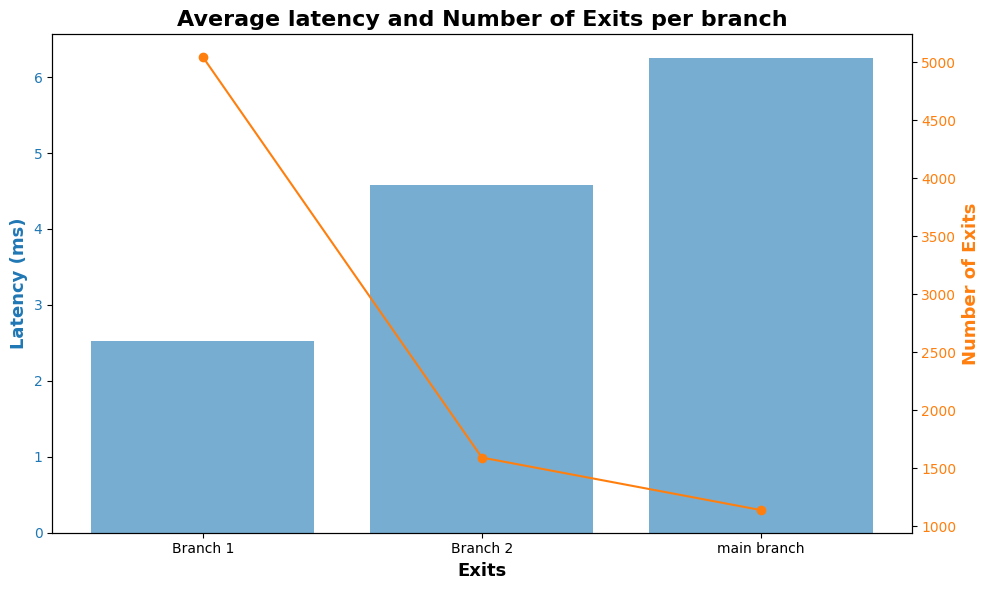

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'Labels': ['Branch 1', 'Branch 2', 'main branch'],
    'Latency': [2.528, 4.582, 6.251],
    'Number of Exits': [5047, 1592, 1139]
}

df = pd.DataFrame(data)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Latency data on the left Y-axis
ax1.set_xlabel('Exits', fontdict={'fontsize': 13, 'fontweight': 'bold', 'color': 'black'})
ax1.set_ylabel('Latency (ms)', color='tab:blue', fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax1.bar(df['Labels'], df['Latency'], color='tab:blue', label='Latency', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create another Y-axis for Number of Exits
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Exits', color='tab:orange',fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax2.plot(df['Labels'], df['Number of Exits'], color='tab:orange', marker='o', linestyle='-', label='Number of Exits')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Adding titles and labels
plt.title('Average latency and Number of Exits per branch',fontdict={'fontsize': 16, 'fontweight': 'bold'})
fig.tight_layout()  # Adjust layout to prevent overlap

# Display the plot
plt.show()


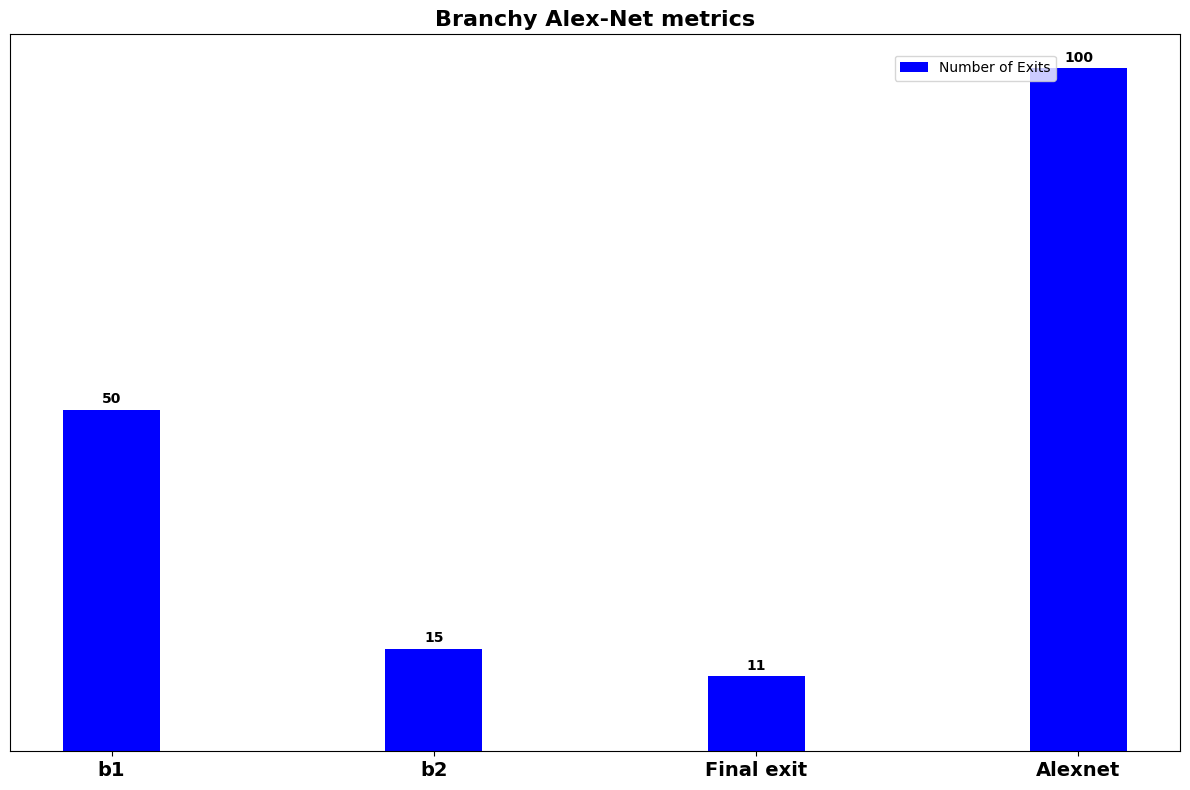

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits']#, 'Latency (100us)',  'Accuracy (%)', 'Data Ingress (Kb)','Flops (million)']
x_labels = ['b1', 'b2', 'Final exit', 'Alexnet']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 12, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 256, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70, 128, 163.0]     # Example values for b3
values_alexnet = [10000, 3.28, 70, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Create a new figure with specified size
fig, ax = plt.subplots(figsize=(12, 8))

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)


# Create an array for the bar positions
bar_width = 0.15  # Width of each bar
spacing_between_bars = 0.05  # Space between individual bars within a group
group_spacing = 0.3  # Spacing between groups

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Plot bars for each characteristic
for i in range(num_bars):
    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + i * (bar_width + spacing_between_bars)

    # Plot bars
    ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        label=categories[i],
        color=colors[i]
    )

    # Add text on top of each bar
    for j in range(num_groups):
        value = data[j][i]
        ax.text(
            positions[j],
            value + 0.5,  # Adjust the position slightly above the bar
            f'{value}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

# Labeling and formatting
ax.set_xticks(np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + (num_bars - 1) * (bar_width + spacing_between_bars) / 2)
ax.set_xticklabels(x_labels,fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_title('Branchy Alex-Net metrics',fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.legend(loc='upper right', bbox_to_anchor=(0.9, 0.98))

# Remove y-axis label
ax.yaxis.set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()
# plt.savefig("branchynet-metrics-no-exit.jpg")

# 

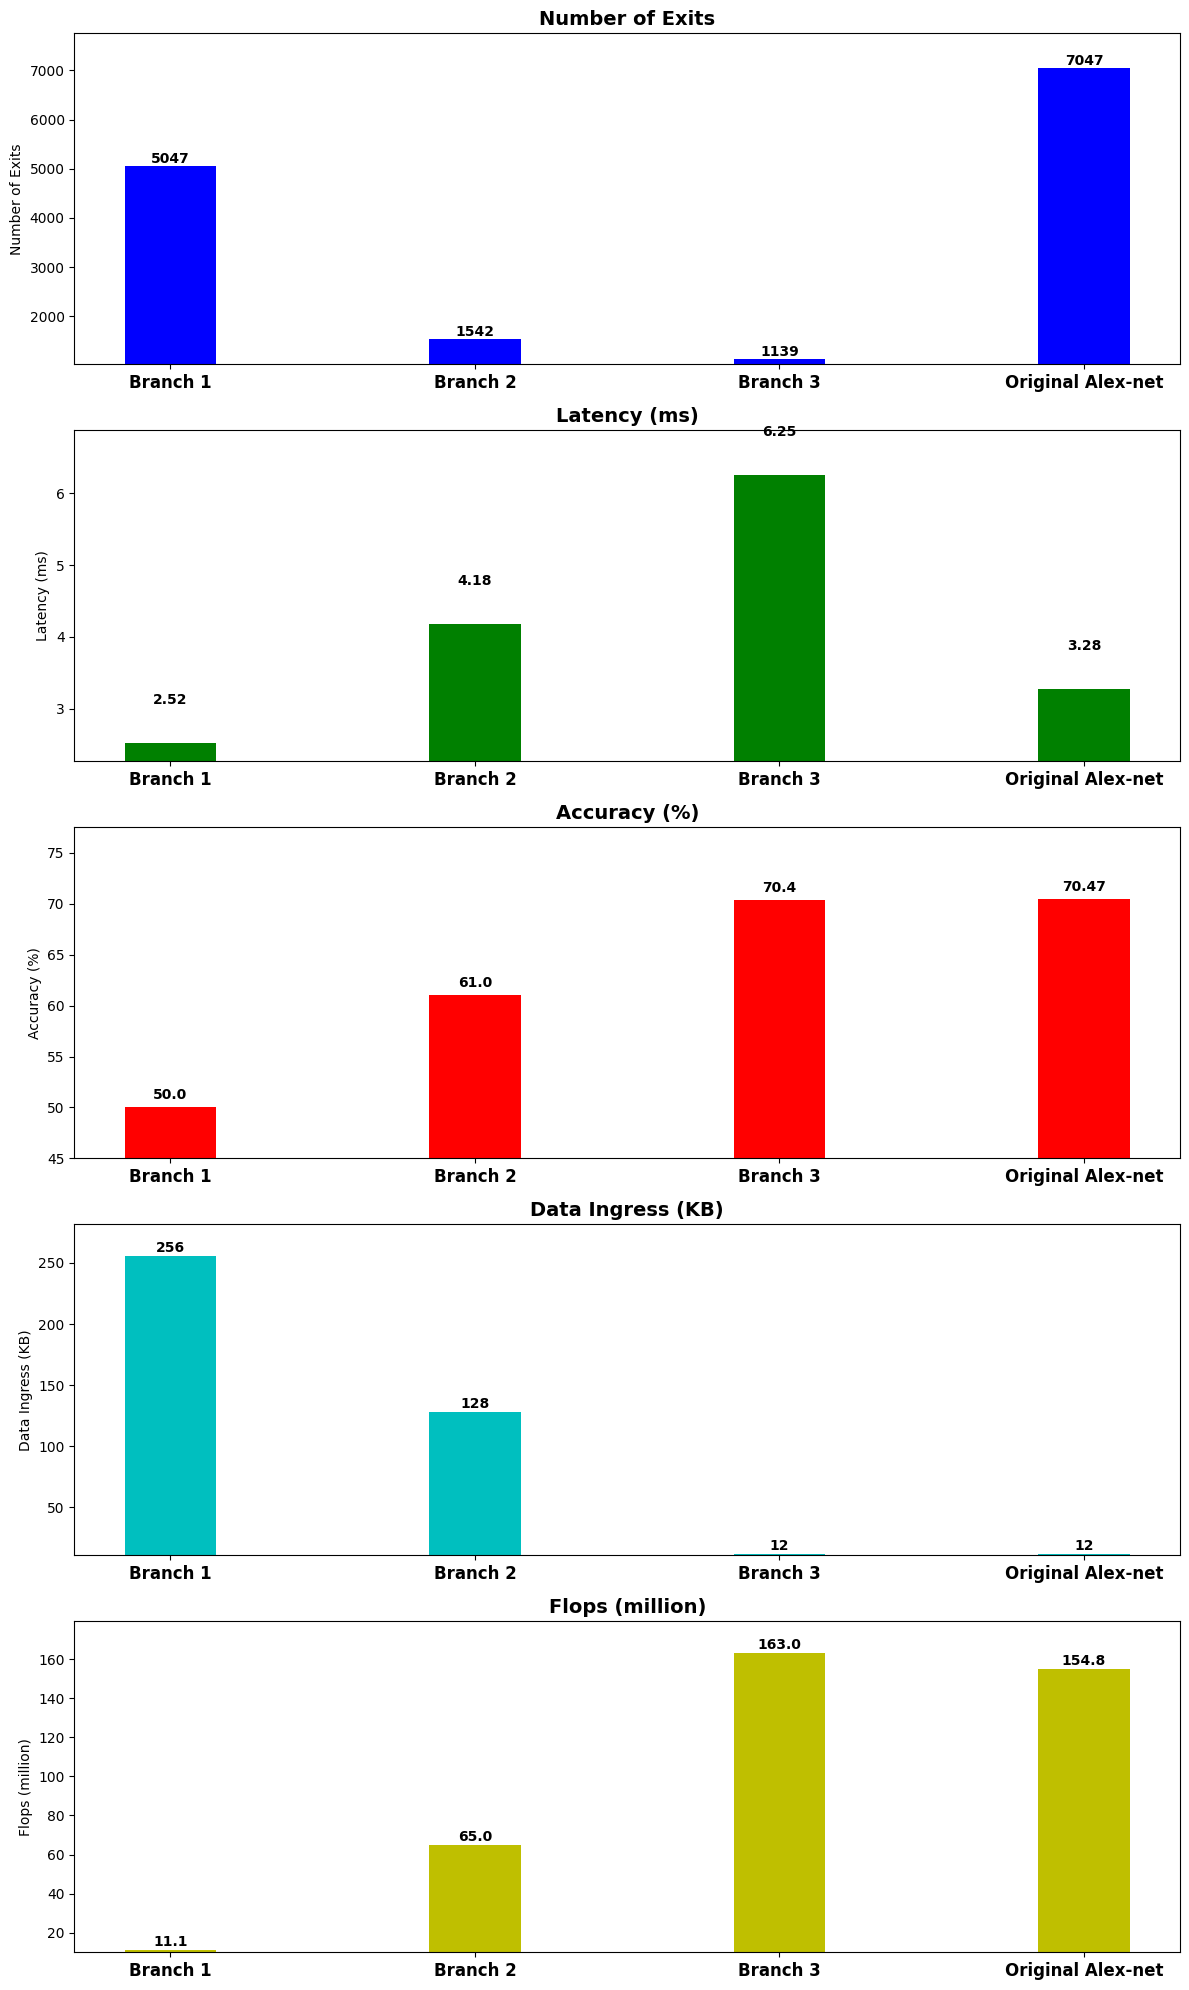

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Create a new figure with specified size
fig, axes = plt.subplots(nrows=num_bars, ncols=1, figsize=(12, 4*num_bars))

# Plot each metric in a separate subplot
bar_width = 0.3  # Reduce bar width
bar_spacing = 0  # Increase bar spacing

# Plot each metric in a separate subplot
for i, ax in enumerate(axes):
    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) 


    # Plot bars for each characteristic
    bars = ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        color=colors[i]
    )

    # Add text on top of each bar
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,  # Adjust the position slightly above the bar
            f'{bar.get_height()}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

    # Labeling and formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels, fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title(categories[i], fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_ylabel(categories[i])

    # Set y-axis range
    min_value = min([data[j][i] for j in range(num_groups)])
    max_value = max([data[j][i] for j in range(num_groups)])
    ax.set_ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))  # Add 10% padding

plt.tight_layout()
plt.show()
# plt.savefig("branchynet-metrics-no-exit.jpg")


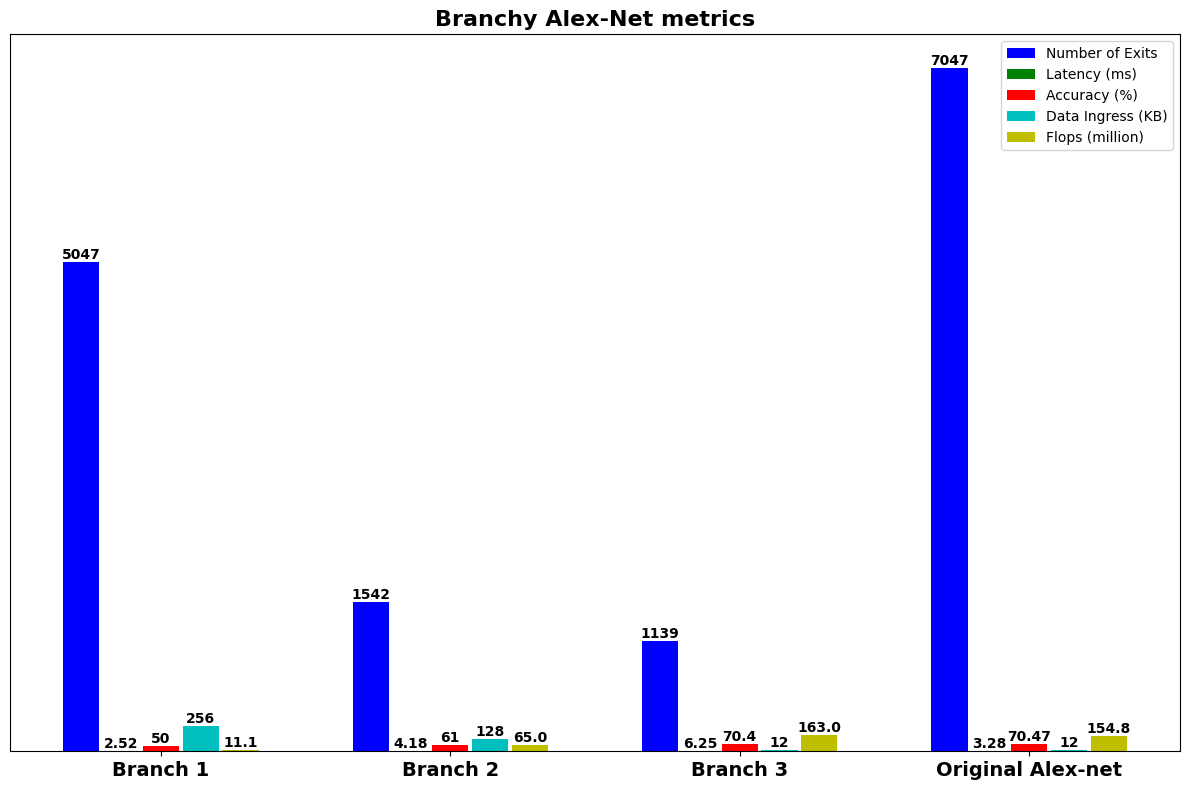

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]       # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Create a new figure with specified size
fig, ax = plt.subplots(figsize=(12, 8))

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Create an array for the bar positions
bar_width = 0.2  # Width of each bar
spacing_between_bars = 0.02  # Space between individual bars within a group
group_spacing = 0.5  # Spacing between groups

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Plot bars for each characteristic
for i in range(num_bars):
    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + i * (bar_width + spacing_between_bars)

    # Plot bars
    ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        label=categories[i],
        color=colors[i]
    )

    # Add text on top of each bar
    for j in range(num_groups):
        value = data[j][i]
        ax.text(
            positions[j],
            value + 0.5,  # Adjust the position slightly above the bar
            f'{value}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

# Labeling and formatting
ax.set_xticks(np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + (num_bars - 1) * (bar_width + spacing_between_bars) / 2)
ax.set_xticklabels(x_labels, fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_title('Branchy Alex-Net metrics', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Remove y-axis label
ax.yaxis.set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()
# plt.savefig("branchynet-metrics-no-exit.jpg")


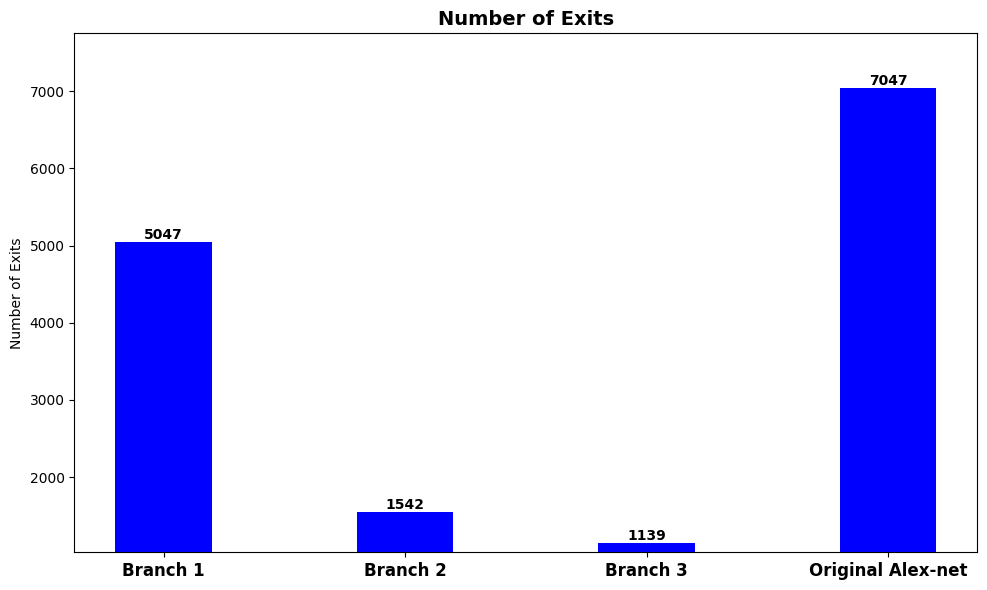

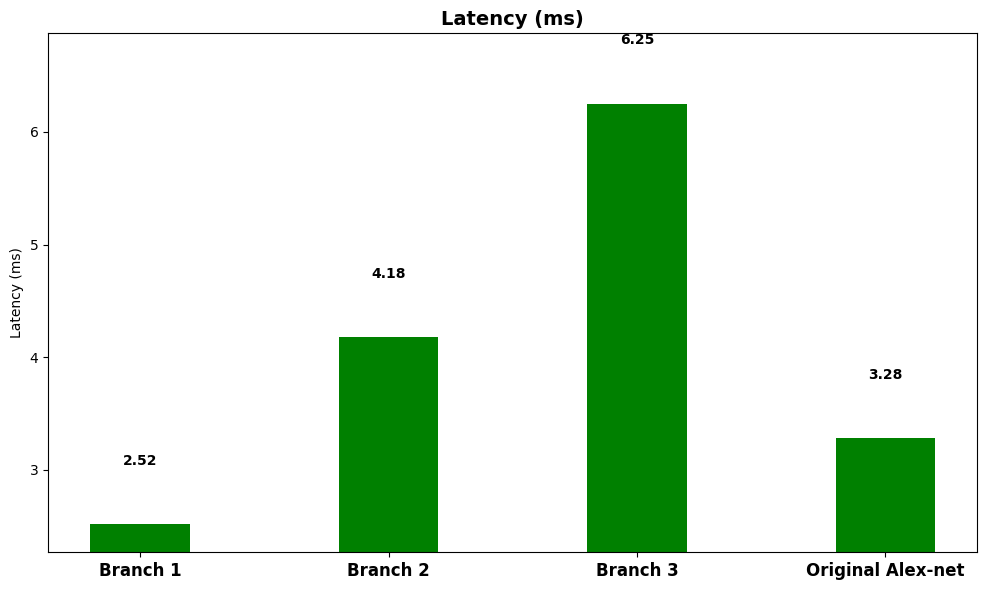

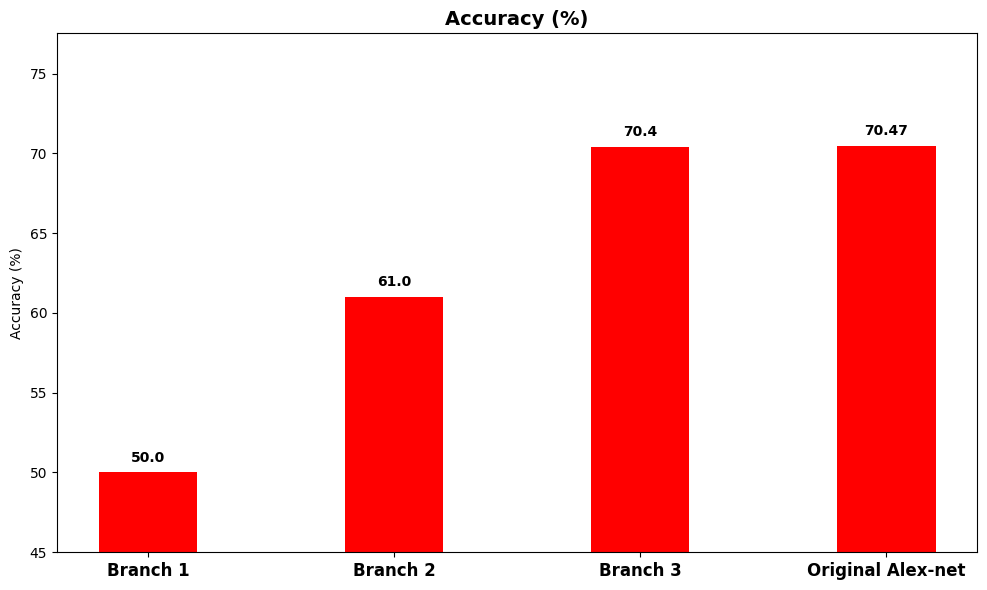

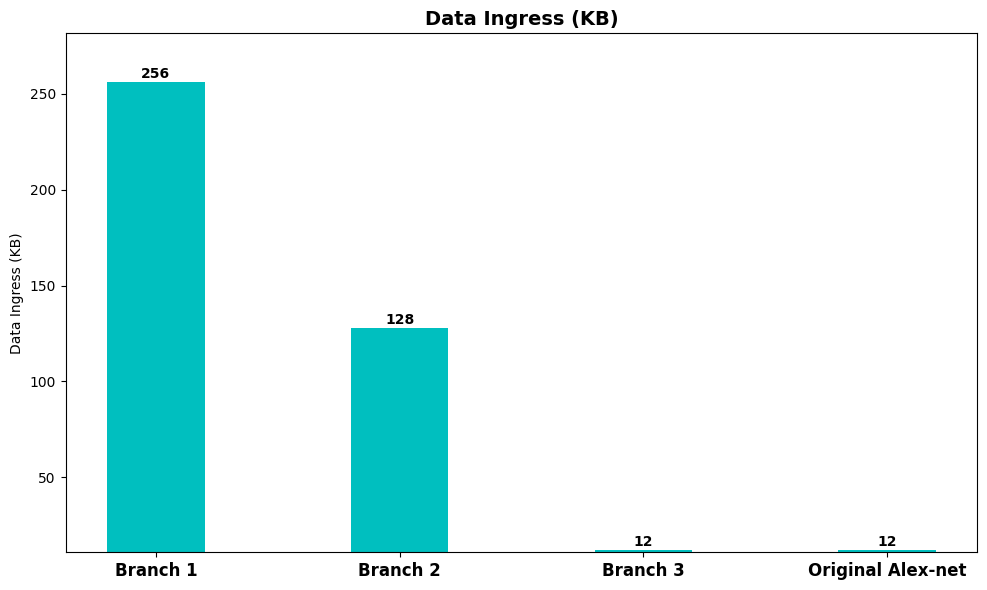

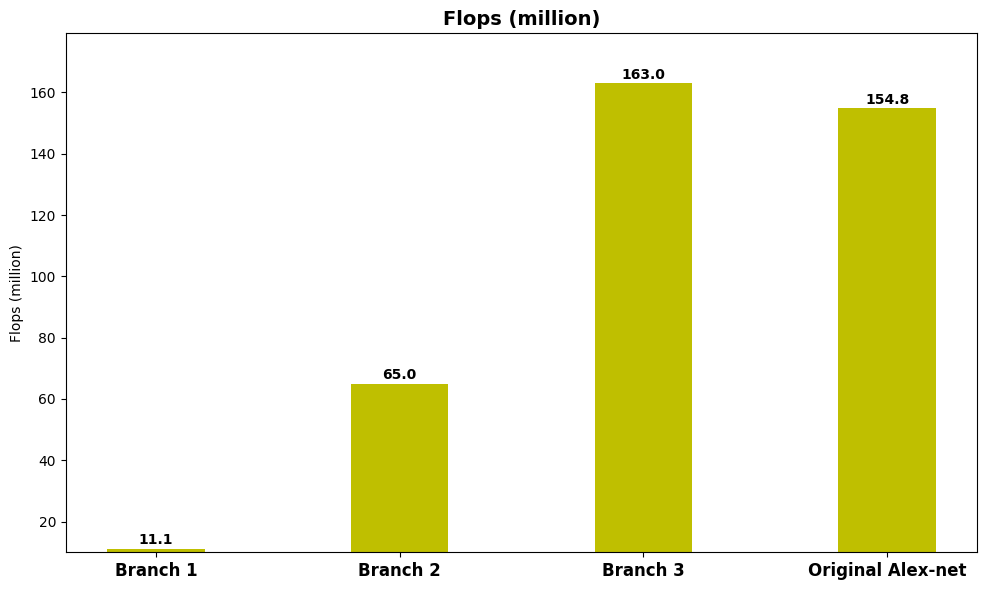

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Bar width
bar_width = 0.4

# Create a new figure for each metric
for i in range(num_bars):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Position of bars on x-axis for this group
    positions = np.arange(num_groups)

    # Plot bars for each characteristic
    bars = ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        color=colors[i]
    )

    # Add text on top of each bar
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,  # Adjust the position slightly above the bar
            f'{bar.get_height()}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

    # Labeling and formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels, fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title(categories[i], fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_ylabel(categories[i])

    # Set y-axis range
    min_value = min([data[j][i] for j in range(num_groups)])
    max_value = max([data[j][i] for j in range(num_groups)])
    ax.set_ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))  # Add 10% padding

    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{categories[i].lower().replace(' ', '_')}-metrics.jpg")


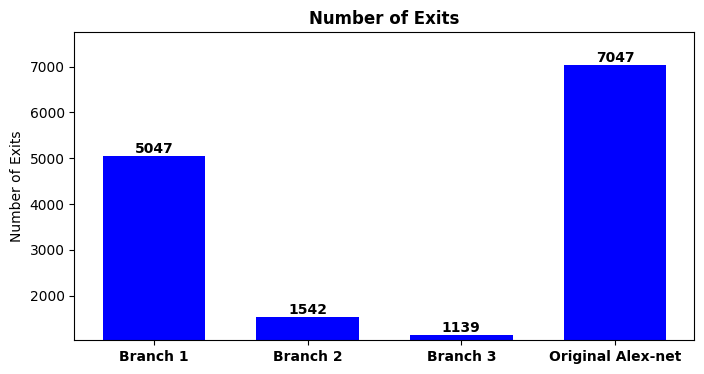

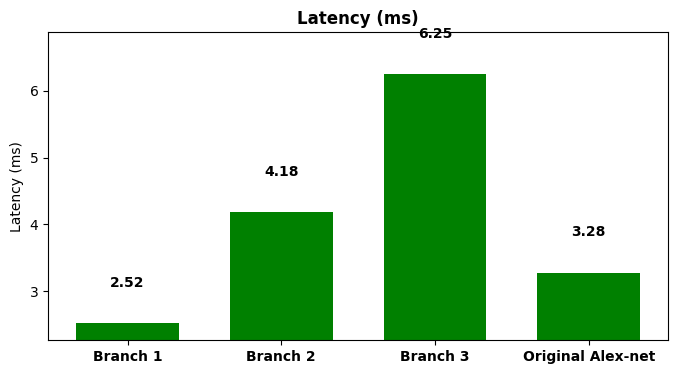

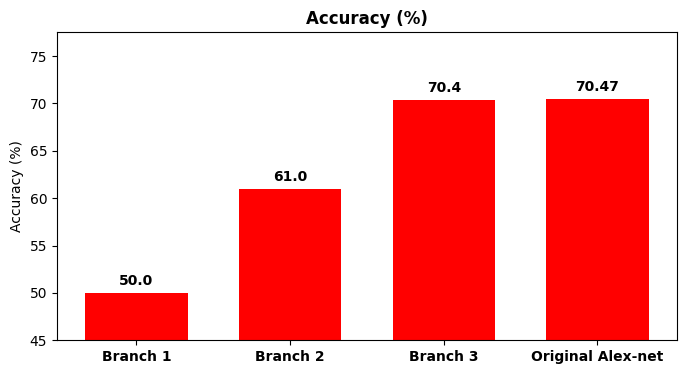

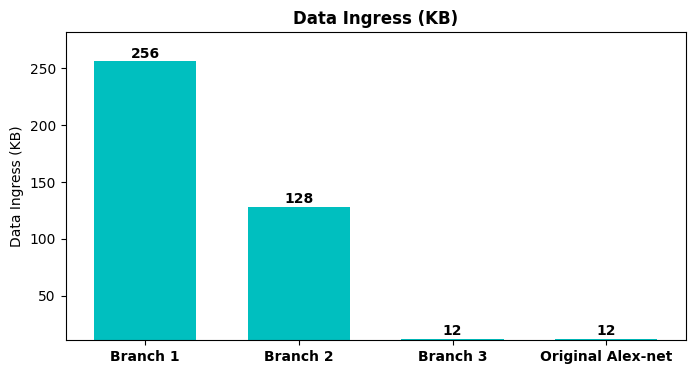

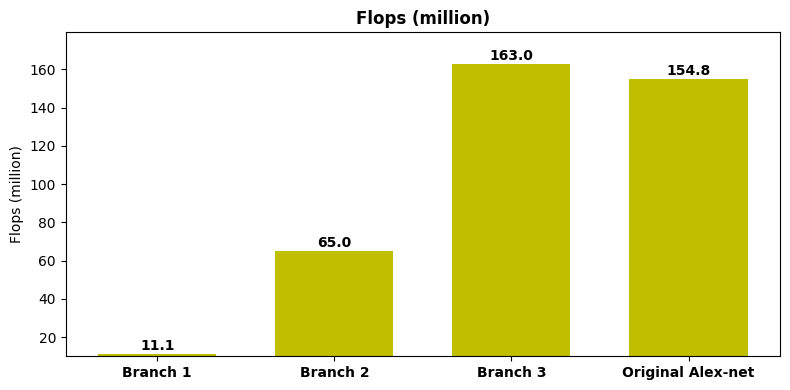

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Bar width
bar_width = 0.2

# Create a new figure for each metric
for i in range(num_bars):
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the width of the figure

    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) *0.3

    # Plot bars for each characteristic
    bars = ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        color=colors[i]
    )

    # Add text on top of each bar
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,  # Adjust the position slightly above the bar
            f'{bar.get_height()}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

    # Labeling and formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels, fontdict={'fontsize': 10, 'fontweight': 'bold'})
    ax.set_title(categories[i], fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_ylabel(categories[i])

    # Set y-axis range
    min_value = min([data[j][i] for j in range(num_groups)])
    max_value = max([data[j][i] for j in range(num_groups)])
    ax.set_ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))  # Add 10% padding

plt.tight_layout()
plt.show()
    # plt.savefig(f"{categories[i].lower().replace(' ', '_')}-metrics.jpg")


In [ ]:
x